# **setup**

In [ ]:
import os
if not os.path.exists("econometrics-portfolio"):
    !git clone https://github.com/suha2502/econometrics-portfolio.git
%cd econometrics-portfolio/02-labour-time-nutrition
!pip install -r packages.txt

In [ ]:
os.makedirs("data/derived", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [ ]:
import zipfile
with zipfile.ZipFile("data/raw/faps_fahnutrients.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("data/raw")

In [ ]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Computer Modern", "DejaVu Serif"],
    "axes.unicode_minus": False})

# **FAPS: data cleaning + processing**

In [1]:
soft_palette = ["#ffc9de", "#ffe0f0", "#f3c4fb", "#c3bef0", "#c6d8ff", "#b7f0ad", "#faffbf"]

In [2]:
import pandas as pd

In [3]:
individual = pd.read_csv('data/raw/faps_individual_puf.csv', low_memory=False)
individual_cols = [
    "BMICAT", "HEALTHSTATUS", "NDINNERSOUT", "EMPLOYMENT", "EDUCCAT", "RACECAT_R",
    "HISPANIC", "AGE_R", "RELATION_R", "SEX", "HHWGT", "PNUM", "HHNUM"]
individual = individual[individual_cols]
individual = individual.rename(columns={'HHNUM': 'hhnum'})

household = pd.read_csv('data/raw/faps_household_puf.csv', low_memory=False)
household_cols = [
    "region", "hhsize", "hhsizechange", "inchhavg_r", "selfemployhh", "housingown", 
    "liqassets", "largeexp", "foodsecureq3", "gardenown", "gardenelse", "huntfish", "dietstatushh", 
    "healthycost", "healthytime", "fincondition", "ndinnersouthh", "nmealshome", "hhnum"]
household = household[household_cols]

hh_nutrients_cols = [
    "chol", "protein", "polyfat", "monofat", "satfat", "totfat",
    "totsug", "dietfiber", "carb", "energy", "foodgroup", "hhnum"]
hh_nutrients = pd.read_csv('data/raw/faps_fahnutrients.csv', low_memory=False)
hh_nutrients = hh_nutrients[hh_nutrients_cols]

faps_cleaned = individual.merge(household, on='hhnum', how='inner')
faps_cleaned = faps_cleaned.merge(hh_nutrients, on='hhnum', how='inner')
faps_cleaned.rename(columns={
    'BMICAT': 'bmi',
    'HEALTHSTATUS': 'self_rated_health',
    'NDINNERSOUT': 'dinners_out_per_week',
    'EMPLOYMENT': 'employment',
    'EDUCCAT': 'education',
    'RACECAT_R': 'race',
    'HISPANIC': 'hispanic',
    'AGE_R': 'age',
    'RELATION_R': 'relationship',
    'SEX': 'sex',
    'HHWGT': 'hh_weight',
    'PNUM': 'person_id',
    'hhnum': 'hh_id',
    'hhsize': 'hh_size',
    'hhsizechange': 'hh_size_change',
    'inchhavg_r': 'avg_hh_income',
    'selfemployhh': 'hh_self_employed',
    'housingown': 'homeownership',
    'liqassets': 'liquid_assets',
    'largeexp': 'large_expenditure_shock',
    'foodsecureq3': 'hh_food_secure',
    'gardenown': 'garden_ownership',
    'gardenelse': 'garden_elsewhere',
    'huntfish': 'hunt_fish',
    'dietstatushh': 'hh_diet_quality',
    'healthycost': 'perceived_healthy_cost',
    'healthytime': 'perceived_healthy_time',
    'fincondition': 'financial_condition',
    'ndinnersouthh': 'hh_dinners_out',
    'nmealshome': 'hh_meals_home',
    'foodgroup': 'food_group',}, inplace=True)

faps_cleaned.to_csv('data/derived/faps_individual_nutrients_household.csv', index=False)

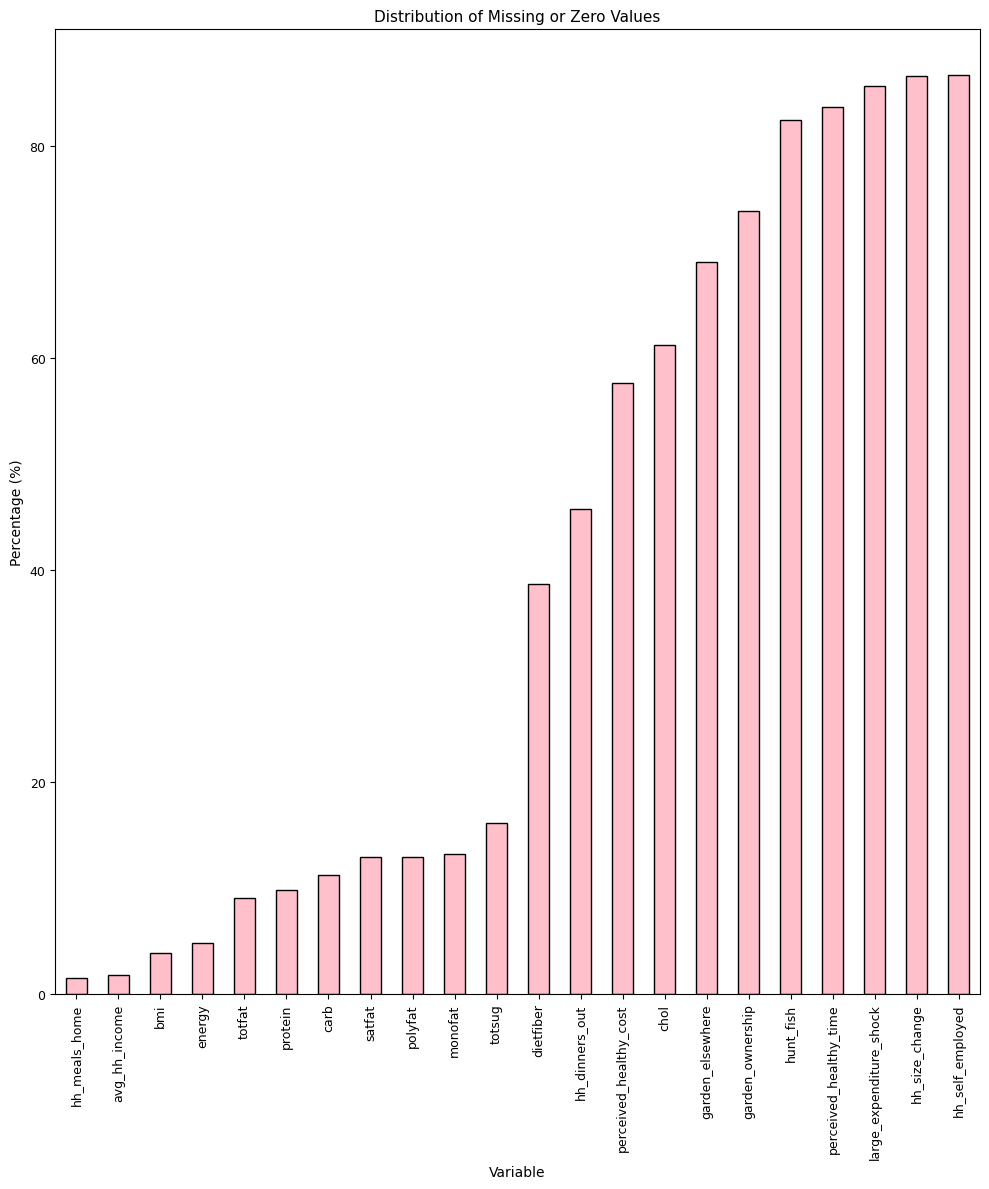

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

nan_zero_percentage = (faps_cleaned.isna().sum() + (faps_cleaned == 0).sum()) / len(faps_cleaned) * 100
nan_zero_filtered = nan_zero_percentage[nan_zero_percentage > 0].sort_values()
nan_zero_percentage_sorted = nan_zero_filtered.sort_values()

plt.figure(figsize=(10, 12))
nan_zero_percentage_sorted.plot(
    kind='bar',
    color='pink',
    edgecolor='black')
plt.title("Distribution of Missing or Zero Values", fontsize=11)
plt.xlabel("Variable", fontsize=10)
plt.ylabel("Percentage (%)", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig("results/faps_missing_zero.png", dpi=300)
plt.show()

In [5]:
nutrients = ['chol', 'protein', 'polyfat', 'monofat', 'satfat', 'totfat', 'totsug', 'dietfiber', 'carb']
zero_stats = pd.DataFrame({
    'zero_count': faps_cleaned[nutrients].isin([0]).sum(),
    'total_count': faps_cleaned[nutrients].notna().sum(),})
zero_stats['zero_percentage'] = (zero_stats['zero_count'] / zero_stats['total_count']) * 100
print(zero_stats.sort_values('zero_percentage', ascending=False))

           zero_count  total_count  zero_percentage
chol           292028       487473        59.906497
dietfiber      178728       487249        36.681040
totsug          64685       486740        13.289436
monofat         50555       487402        10.372342
polyfat         49205       487402        10.095363
satfat          48883       487416        10.029010
carb            40826       487584         8.373121
protein         33378       487584         6.845590
totfat          29844       487584         6.120791


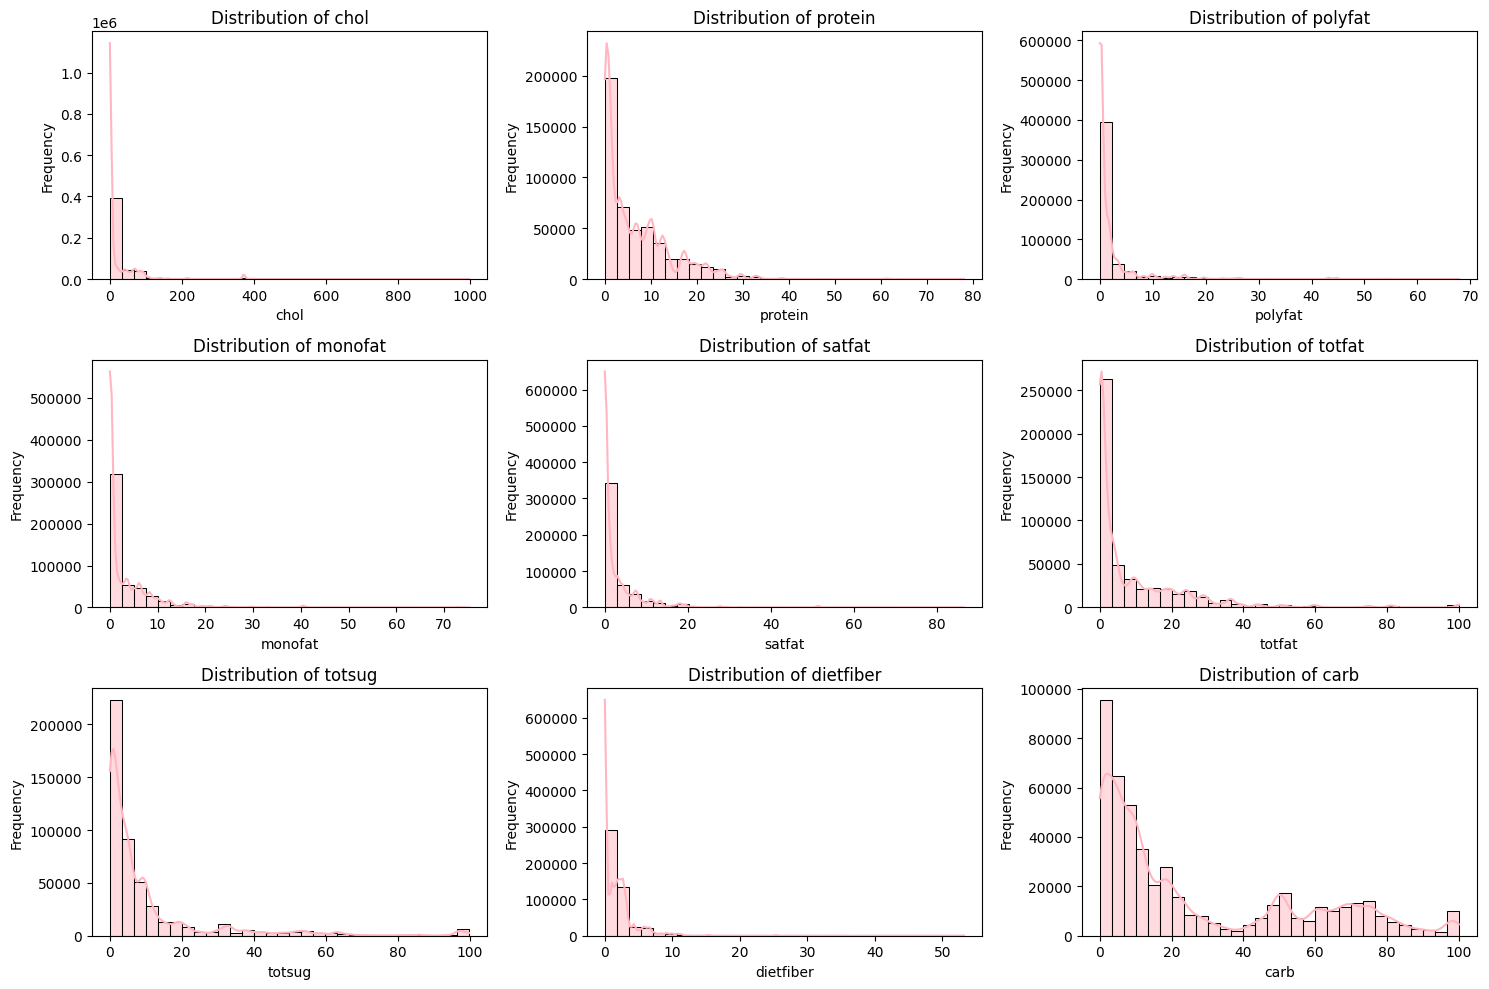

In [6]:
plt.figure(figsize=(15, 10))
for i, var in enumerate(nutrients, 1):
    plt.subplot(3, 3, i)
    sns.histplot(faps_cleaned[var].dropna(), kde=True, bins=30, color='lightpink')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("results/faps_missing_zero_nutrients.png", dpi=300)
plt.show()

In [7]:
for var in nutrients:
    skew = faps_cleaned[var].skew()
    if skew > 1:
        print(f'{var} is right-skewed (skew={skew:.2f}) → impute using median')
    elif skew < -1:
        print(f'{var} is left-skewed (skew={skew:.2f}) → impute using median') 
    else:
        print(f'{var} is approximately normal (skew={skew:.2f}) → impute using mean')

chol is right-skewed (skew=4.78) → impute using median
protein is right-skewed (skew=1.50) → impute using median
polyfat is right-skewed (skew=5.30) → impute using median
monofat is right-skewed (skew=4.07) → impute using median
satfat is right-skewed (skew=4.09) → impute using median
totfat is right-skewed (skew=2.87) → impute using median
totsug is right-skewed (skew=2.96) → impute using median
dietfiber is right-skewed (skew=5.57) → impute using median
carb is approximately normal (skew=0.94) → impute using mean


In [8]:
right_skew = ['chol', 'protein', 'polyfat', 'monofat', 'satfat', 'totfat', 'totsug', 'dietfiber']
for col in right_skew:
    faps_cleaned[col] = pd.to_numeric(faps_cleaned[col], errors='coerce')
    faps_cleaned[col] = faps_cleaned[col].fillna(faps_cleaned[col].median())

normal = ['carb']
for col in normal:
    faps_cleaned[col] = pd.to_numeric(faps_cleaned[col], errors='coerce')
    faps_cleaned[col] = faps_cleaned[col].fillna(faps_cleaned[col].mean())

In [9]:
from pyhere import here
import statsmodels.api as sm
import numpy as np

for column in faps_cleaned.columns:
    print(f"\nUnique values in {column}:")
    print(faps_cleaned[column].unique())


Unique values in bmi:
['2' '1' '3' 'V' nan 'E']

Unique values in self_rated_health:
['2' '1' '4' '3' '5' 'D' 'R']

Unique values in dinners_out_per_week:
['1' '3' '5' '7' '0' '2' '4' '6' 'D' 'R']

Unique values in employment:
['1' 'V' '5' '4' '2' '3' 'R']

Unique values in education:
['3' '4' 'V' '2' '1' '6' '5' 'D' 'R']

Unique values in race:
['1' '2' '5' '4' '6' '3' 'R']

Unique values in hispanic:
['0' '1' 'R']

Unique values in age:
['47.5' '27.5' '13.5' '9.5' '62.5' '16.5' '0' '68' '5' '2' '1' '6.5' '85'
 '3' '18' '19' '4' '40' 'D']

Unique values in relationship:
['0' '1' '3' '7' '4' '8' '5' '2' '6' 'R']

Unique values in sex:
['1' '2' 'R']

Unique values in hh_weight:
[ 6056.9134119 26741.184558  31665.579066  ... 12542.643743   5245.2291093
 18841.727215 ]

Unique values in person_id:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Unique values in hh_id:
[100012 100015 100024 ... 120077 120078 120080]

Unique values in region:
[3 2 1 4]

Unique values in hh_size:
[ 5  1  2  7 

In [10]:
faps_cleaned['bmi'] = faps_cleaned['bmi'].replace({'V': np.nan, 'E': np.nan})
faps_cleaned['bmi'] = faps_cleaned['bmi'].astype(str).replace({'1': "Healthy", '2': "Overweight", '3': "Obese"})

faps_cleaned['self_rated_health'] = faps_cleaned['self_rated_health'].replace({'D': np.nan, 'R': np.nan})
faps_cleaned['self_rated_health'] = faps_cleaned['self_rated_health'].astype(str).map({
    '1': "Excellent", '2': "Very Good", '3': "Good", '4': "Fair", '5': "Poor"})

faps_cleaned['dinners_out_per_week'] = faps_cleaned['dinners_out_per_week'].replace({'D': np.nan, 'R': np.nan})
faps_cleaned['dinners_out_per_week'] = pd.to_numeric(faps_cleaned['dinners_out_per_week'], errors='coerce')
faps_cleaned['dinners_out_per_week'] = faps_cleaned['dinners_out_per_week'].apply(
    lambda x: 'Never' if x == 0 else 
              'Sometimes' if x in [1, 2] else 
              'Often' if x > 2 else np.nan)

faps_cleaned['employment'] = faps_cleaned['employment'].replace({'V': np.nan, 'R': np.nan})
faps_cleaned['employment'] = pd.to_numeric(faps_cleaned['employment'], errors='coerce')
faps_cleaned['employment'] = faps_cleaned['employment'].apply(lambda x: 1 if x in [1, 2] else (0 if x in [3, 4, 5] else np.nan))

faps_cleaned['education'] = faps_cleaned['education'].replace({'V': np.nan, 'D': np.nan, 'R': np.nan})
faps_cleaned['education'] = faps_cleaned['education'].astype(str).map({
    '1': "< High School", '2': "< High School", '3': "High School", 
    '4': "< Bachelor's", '5': "Bachelor's", '6': "Master's"})

faps_cleaned['race'] = faps_cleaned['race'].replace({'1': "White", '2': "Black", '3': "American Indian/Alaska Native", '4': "Asian/Native Hawaiian/Other Pacific Islander", '5': "Other", '6': "Other", 'R': np.nan})

faps_cleaned['hispanic'] = pd.to_numeric(faps_cleaned['hispanic'], errors='coerce')
faps_cleaned['hispanic'] = faps_cleaned['hispanic'].apply(lambda x: 1 if x == 1 else (0 if x == 0 else np.nan))

faps_cleaned['age'] = faps_cleaned['age'].replace({'D': np.nan})
faps_cleaned['age'] = pd.to_numeric(faps_cleaned['age'], errors='coerce')
faps_cleaned['age'] = faps_cleaned['age'].apply(lambda x: "< 18" if x < 18 else 
                                 ("18-35" if 18 <= x < 40 else 
                                  ("40-65" if 40 <= x < 65 else 
                                   ("65+" if x >= 65 else np.nan))))

faps_cleaned['relationship'] = faps_cleaned['relationship'].replace({'R': np.nan})
relation_map = {
    '0': "Self", '1': "Spouse", '2': "Unmarried Partner", '3': "Child", 
    '4': "Grandchild", '5': "Parent", '6': "Sibling", 
    '7': "Other", '8': "Other"}
faps_cleaned['relationship'] = faps_cleaned['relationship'].map(relation_map)

faps_cleaned['sex'] = faps_cleaned['sex'].replace({'R': np.nan})
faps_cleaned['sex'] = pd.to_numeric(faps_cleaned['sex'], errors='coerce')
faps_cleaned['sex'] = faps_cleaned['sex'].apply(lambda x: 1 if x == 1 else (0 if x == 2 else np.nan))

faps_cleaned.head(5)

,bmi,self_rated_health,dinners_out_per_week,employment,education,race,hispanic,age,relationship,sex,...,protein,polyfat,monofat,satfat,totfat,totsug,dietfiber,carb,energy,food_group
0,Overweight,Very Good,Sometimes,1.0,High School,White,0.0,40-65,Self,1.0,...,9.87,1.594,0.901,0.885,3.76,6.37,2.1,50.15,278.0,10201
1,Overweight,Very Good,Sometimes,1.0,High School,White,0.0,40-65,Self,1.0,...,0.07,0.000,0.000,0.000,0.02,8.97,0.0,9.56,37.0,70304
2,Overweight,Very Good,Sometimes,1.0,High School,White,0.0,40-65,Self,1.0,...,0.07,0.000,0.000,0.000,0.02,8.97,0.0,9.56,37.0,70304
3,Overweight,Very Good,Sometimes,1.0,High School,White,0.0,40-65,Self,1.0,...,10.94,1.989,4.839,4.714,13.57,3.40,2.1,27.53,276.0,60201
4,Overweight,Very Good,Sometimes,1.0,High School,White,0.0,40-65,Self,1.0,...,0.07,0.000,0.000,0.000,0.02,8.97,0.0,9.56,37.0,70304


In [11]:
region_map = {1: "Northeast", 2: "Midwest", 3: "South", 4: "West"}
faps_cleaned['region'] = faps_cleaned['region'].map(region_map)
faps_cleaned['hh_size'] = faps_cleaned['hh_size'].apply(lambda x: "Individual" if x == 1 else 
                                  ("Small Family" if 2 <= x <= 4 else 
                                   ("Big Family" if 4 < x <= 6 else 
                                    ("Large Family" if 7 <= x <= 14 else np.nan))))
faps_cleaned = faps_cleaned[faps_cleaned['hh_size_change'] != -997] 
faps_cleaned = faps_cleaned[~faps_cleaned['homeownership'].isin([-997, -998])]
faps_cleaned['homeownership'] = faps_cleaned['homeownership'].replace({'3': np.nan, 1: 0, 2: 1})  
faps_cleaned['liquid_assets'] = faps_cleaned['liquid_assets'].replace([-997, -998], np.nan).map({1: "Low", 2: "Medium", 3: "Medium", 4: "High"})
faps_cleaned = faps_cleaned[~faps_cleaned['large_expenditure_shock'].isin([-997, -998])]
faps_cleaned['hh_food_secure'] = faps_cleaned['hh_food_secure'].replace(-997, np.nan).apply(lambda x: 0 if x in [1, 2] else (1 if x == 3 else np.nan))
faps_cleaned['hh_diet_quality'] = faps_cleaned['hh_diet_quality'].replace([-996, -997, -998], np.nan).map({
    1: "Excellent", 2: "Very good", 3: "Good", 4: "Fair", 5: "Poor"})
faps_cleaned = faps_cleaned[faps_cleaned['perceived_healthy_cost'] != -997]
faps_cleaned = faps_cleaned[faps_cleaned['perceived_healthy_time'] != -997]
faps_cleaned['financial_condition'] = faps_cleaned['financial_condition'].replace([-997, -998], np.nan).map({
    1: "Very Comfortable", 2: "Comfortable", 3: "Struggling", 4: "Struggling", 5: "Struggling"})
faps_cleaned['hh_dinners_out'] = faps_cleaned['hh_dinners_out'].replace([-996, -997, -998], np.nan).apply(
    lambda x: 'Never' if x == 0 else 
              ('Sometimes' if x in [1, 2, 3] else 
               'Often' if x in [4, 5, 6, 7] else np.nan))
faps_cleaned['hh_meals_home'] = faps_cleaned['hh_meals_home'].replace(-997, np.nan).apply(
    lambda x: 'Never' if x == 0 else
              ('Sometimes' if 1 <= x <= 3 else
               'Often' if 4 <= x <= 7 else
               'Very Often' if x >= 20 else np.nan))
faps_cleaned['hh_self_employed'] = faps_cleaned['hh_self_employed'].replace(-998, np.nan)

def categorize_food(food_group):
    fresh_foods = {
        # fresh vegetables
        20101, 20102, 20103, 20201, 20301, 20302, 20303, 
        20401, 20402, 20403, 20501, 20502, 20503, 20601,
        20602, 20603,
        # fresh fruits
        30101, 30102, 30103, 30104,
        # dairy
        40101, 40201, 40203, 40301,
        # meats
        50101, 50201, 50301, 50401, 50601, 50701,
        # raw nuts/seeds
        50401,
        # water
        70306
}
    processed_foods = {
        # processed whole-grain foods
        10201, 10202, 10203, 10204,
        # processed vegetables
        20203, 20303, 20403,
        # processed fruits
        30201,
        # processed dairy
        40102, 40103, 40202, 40302,
        # processed meats
        50102, 50103, 50202, 50203, 50302, 50303, 50501, 50602,
        # processed nuts/seeds
        50402,
        # prepared meals
        60101, 60201, 60301, 60401,
        # snacks & sweets
        70501, 70502, 70301, 70302, 70303, 70304, 70401, 70402, 70403, 70404,
        # beverages
        70305,
        # others
        70601, 70701, 70801
    }
    if food_group in fresh_foods:
        return "Fresh"
    elif food_group in processed_foods:
        return "Processed"
    else:
        return "Other"
faps_cleaned['food_type'] = faps_cleaned['food_group'].apply(categorize_food)
unique_values = faps_cleaned['food_type'].unique()
print(unique_values)

['Processed' 'Other' 'Fresh']


In [12]:
print("\nMissing values by nutrient:")
print(faps_cleaned[nutrients].isna().sum())

print("\nGroup sizes by food_type:")
print(faps_cleaned['food_type'].value_counts())

avg_nutrition = (
    faps_cleaned.groupby('food_type')[nutrients]
    .mean(numeric_only=True)
    .dropna(axis=1, how='all'))

print("\navg_nutrition shape:", avg_nutrition.shape)
print(avg_nutrition.head())


Missing values by nutrient:
chol         0
protein      0
polyfat      0
monofat      0
satfat       0
totfat       0
totsug       0
dietfiber    0
carb         0
dtype: int64

Group sizes by food_type:
food_type
Processed    274680
Fresh        159242
Other         68414
Name: count, dtype: int64

avg_nutrition shape: (3, 9)
                chol   protein   polyfat   monofat    satfat     totfat  \
food_type                                                                 
Fresh      27.942521  6.059344  0.606512  1.806202  2.098281   5.004128   
Other      11.189011  4.081651  4.478547  4.614528  4.154711  14.219760   
Processed  17.307403  7.714008  2.273953  3.458744  2.974034   9.509790   

              totsug  dietfiber       carb  
food_type                                   
Fresh       5.261089   1.602457   9.539143  
Other      12.336356   2.682623  30.326167  
Processed  12.504581   1.680283  36.036228  


In [13]:
nutrients_raw = faps_cleaned.copy()
avg_nutrition = nutrients_raw.groupby('food_type')[nutrients].mean(numeric_only=True)
avg_nutrition_plot = avg_nutrition.T.sort_values(by='Processed', ascending=False)

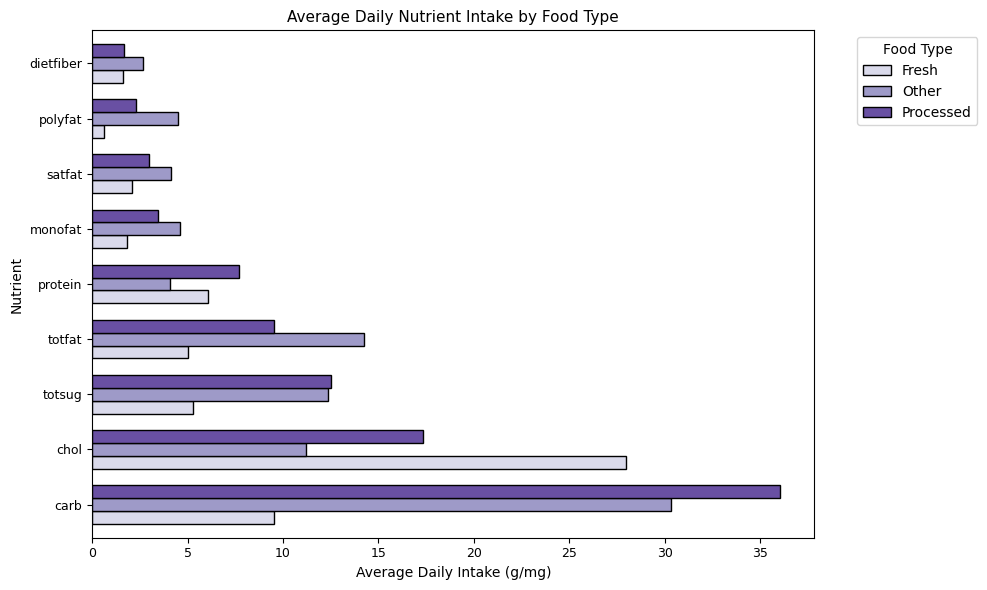

In [14]:
purple_palette = sns.color_palette("Purples", n_colors=avg_nutrition_plot.shape[1])

fig, ax = plt.subplots(figsize=(10, 6))
avg_nutrition_plot.plot(
    kind='barh',
    edgecolor='black',
    ax=ax,
    width=0.7,
    color=purple_palette,
    legend=True
)
plt.title("Average Daily Nutrient Intake by Food Type", fontsize=11)
plt.xlabel("Average Daily Intake (g/mg)", fontsize=10)
plt.xticks(fontsize=9)
plt.ylabel("Nutrient", fontsize=10)
plt.yticks(fontsize=9)
plt.legend(title="Food Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("results/faps_nutrition_foodtype.png", dpi=300)
plt.show()

In [15]:
def categorize_cholesterol(cholesterol):
    if cholesterol == 997:
        return np.nan
    elif cholesterol <= 50:
        return 'Below'
    elif 51 <= cholesterol <= 150:
        return 'Meets'
    elif cholesterol > 150:
        return 'Exceeds'
    return np.nan
faps_cleaned['chol'] = faps_cleaned['chol'].apply(categorize_cholesterol)

def categorize_protein(protein):
    if pd.isna(protein) or protein <= 0:
        return np.nan
    elif protein <= 5:
        return 'Below'
    elif 5.1 <= protein <= 20:
        return 'Meets'
    elif protein > 20:
        return 'Exceeds'
    return np.nan
faps_cleaned['protein'] = faps_cleaned['protein'].apply(categorize_protein)

def categorize_fat(fat_value, fat_type):
    if pd.isna(fat_value) or fat_value == 0 or fat_value == 997:
        return np.nan
    if fat_type == 'Saturated Fatty Acids':
        if fat_value <= 3:
            return 'Acceptable'
        elif fat_value > 3:
            return 'Exceeds'
    elif fat_type == 'Polyunsaturated Fatty Acids':
        if fat_value <= 10:
            return 'Acceptable'
        elif fat_value > 10:
            return 'Exceeds'
    elif fat_type == 'Monounsaturated Fatty Acids':
        if fat_value <= 10:
            return 'Acceptable'
        elif fat_value > 10:
            return 'Exceeds'
    elif fat_type == 'Total Fat':
        if fat_value <= 20:
            return 'Acceptable'
        elif fat_value > 20:
            return 'Exceeds'
    return np.nan
faps_cleaned['polyfat'] = faps_cleaned['polyfat'].apply(lambda x: categorize_fat(x, 'Polyunsaturated Fatty Acids'))
faps_cleaned['monofat'] = faps_cleaned['monofat'].apply(lambda x: categorize_fat(x, 'Monounsaturated Fatty Acids'))
faps_cleaned['satfat'] = faps_cleaned['satfat'].apply(lambda x: categorize_fat(x, 'Saturated Fatty Acids'))
faps_cleaned['totfat'] = faps_cleaned['totfat'].apply(lambda x: categorize_fat(x, 'Total Fat'))

def categorize_sugars(sugars):
    if pd.isna(sugars) or sugars == 997:
        return np.nan
    elif sugars <= 5:
        return 'Acceptable'
    else:
        return 'Exceeds'
faps_cleaned['totsug'] = faps_cleaned['totsug'].apply(categorize_sugars)

def categorize_fiber(fiber):
    if pd.isna(fiber) or fiber == 997:
        return np.nan
    elif fiber < 5:
        return 'Below'
    elif fiber >= 5:
        return 'Acceptable'
    return np.nan
faps_cleaned['dietfiber'] = faps_cleaned['dietfiber'].apply(categorize_fiber)

def categorize_carbs(carb):
    if pd.isna(carb) or carb == 997:
        return np.nan
    elif carb <= 15:
        return 'Below'
    elif 15 < carb <= 30:
        return 'Meets'
    elif carb > 30:
        return 'Exceeds'
    return np.nan
faps_cleaned['carb'] = faps_cleaned['carb'].apply(categorize_carbs)

print(faps_cleaned[['chol', 'protein', 'satfat', 'monofat', 'polyfat', 'totfat', 'totsug', 'dietfiber', 'carb']].head())

    chol protein      satfat     monofat     polyfat      totfat      totsug  \
0  Below   Meets  Acceptable  Acceptable  Acceptable  Acceptable     Exceeds   
1  Below   Below         NaN         NaN         NaN  Acceptable     Exceeds   
2  Below   Below         NaN         NaN         NaN  Acceptable     Exceeds   
3  Below   Meets     Exceeds  Acceptable  Acceptable  Acceptable  Acceptable   
4  Below   Below         NaN         NaN         NaN  Acceptable     Exceeds   

  dietfiber     carb  
0     Below  Exceeds  
1     Below    Below  
2     Below    Below  
3     Below    Meets  
4     Below    Below  


# **FAPS: data analysis**

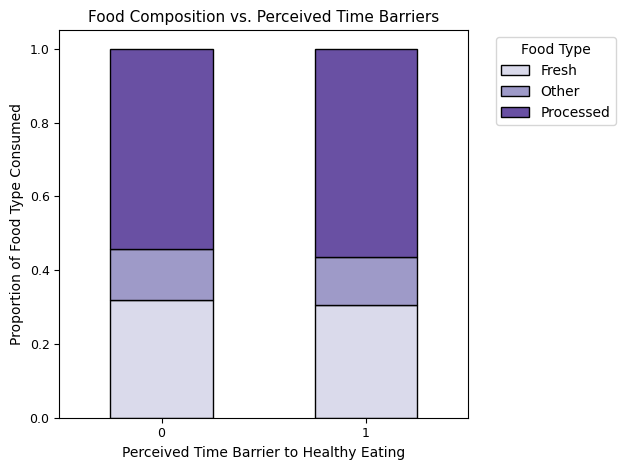

In [16]:
purple_palette = sns.color_palette("Purples", n_colors=len(faps_cleaned['food_type'].unique()))

crosstab = pd.crosstab(
    faps_cleaned['perceived_healthy_time'],
    faps_cleaned['food_type'],
    normalize='index'
)

crosstab.plot(
    kind='bar',
    stacked=True,
    color=purple_palette,
    edgecolor='black'
)

plt.title("Food Composition vs. Perceived Time Barriers", fontsize=11)
plt.xlabel("Perceived Time Barrier to Healthy Eating", fontsize=10)
plt.ylabel("Proportion of Food Type Consumed", fontsize=10)
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=9)
plt.legend(title='Food Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("results/faps_perceivedtime_foodtype.png", dpi=300)
plt.show()

In [17]:
faps_cleaned = faps_cleaned.drop(columns=['education'], errors='ignore')
columns_to_convert = [
    'perceived_healthy_time', 'perceived_healthy_cost', 'hunt_fish', 'garden_elsewhere', 'garden_ownership', 
    'hh_food_secure', 'large_expenditure_shock', 'homeownership', 'hh_self_employed', 
    'hh_size_change', 'sex', 'hispanic', 'employment'
]
for col in columns_to_convert:
    print(f"\nOriginal '{col}':")
    print(faps_cleaned[col].unique())
    faps_cleaned = faps_cleaned.dropna(subset=[col])
    faps_cleaned[col] = faps_cleaned[col].astype(int)
    print(f"Cleaned '{col}':")
    print(faps_cleaned[col].unique())
    print('-' * 50)


Original 'perceived_healthy_time':
[1 0]
Cleaned 'perceived_healthy_time':
[1 0]
--------------------------------------------------

Original 'perceived_healthy_cost':
[0 1]
Cleaned 'perceived_healthy_cost':
[0 1]
--------------------------------------------------

Original 'hunt_fish':
[1 0]
Cleaned 'hunt_fish':
[1 0]
--------------------------------------------------

Original 'garden_elsewhere':
[1 0]
Cleaned 'garden_elsewhere':
[1 0]
--------------------------------------------------

Original 'garden_ownership':
[1 0]
Cleaned 'garden_ownership':
[1 0]
--------------------------------------------------

Original 'hh_food_secure':
[ 0.  1. nan]
Cleaned 'hh_food_secure':
[0 1]
--------------------------------------------------

Original 'large_expenditure_shock':
[0 1]
Cleaned 'large_expenditure_shock':
[0 1]
--------------------------------------------------

Original 'homeownership':
[0 1 3]
Cleaned 'homeownership':
[0 1 3]
--------------------------------------------------

Origi

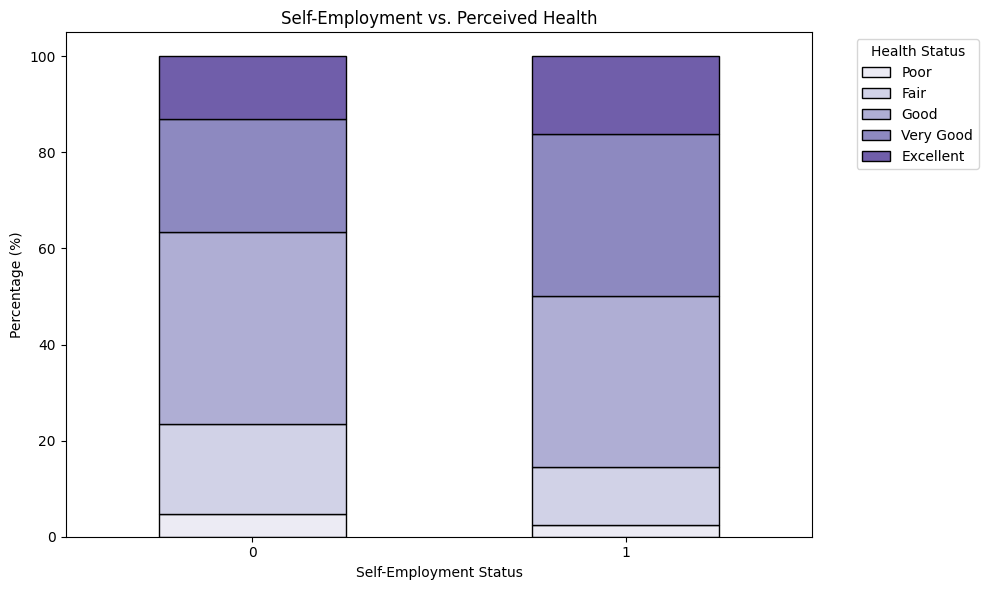

In [18]:
for col in columns_to_convert:
    faps_cleaned[col] = faps_cleaned[col].astype('category')
category_orders = {
    'self_rated_health': ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']}
for var, order in category_orders.items():
    faps_cleaned[var] = pd.Categorical(faps_cleaned[var], categories=order, ordered=True)

purple_palette = sns.color_palette("Purples", n_colors=6)
[(0.93, 0.92, 0.96),
 (0.82, 0.82, 0.90),
 (0.69, 0.68, 0.83),
 (0.55, 0.54, 0.75),
 (0.44, 0.37, 0.67),
 (0.34, 0.17, 0.57)]

faps_cleaned_grouped = faps_cleaned.groupby(['hh_self_employed', 'self_rated_health'], observed=True).size().unstack()
faps_cleaned_percent = faps_cleaned_grouped.div(faps_cleaned_grouped.sum(axis=1), axis=0) * 100
faps_cleaned_percent.plot(kind='bar', stacked=True, color=purple_palette[:faps_cleaned_percent.shape[1]],  edgecolor='black', figsize=(10, 6))
plt.ylabel("Percentage (%)")
plt.title("Self-Employment vs. Perceived Health")
plt.xlabel("Self-Employment Status")
plt.xticks(rotation=0)
plt.legend(title="Health Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'results/faps_selfemployment_perceivedhealth.png')
plt.show()

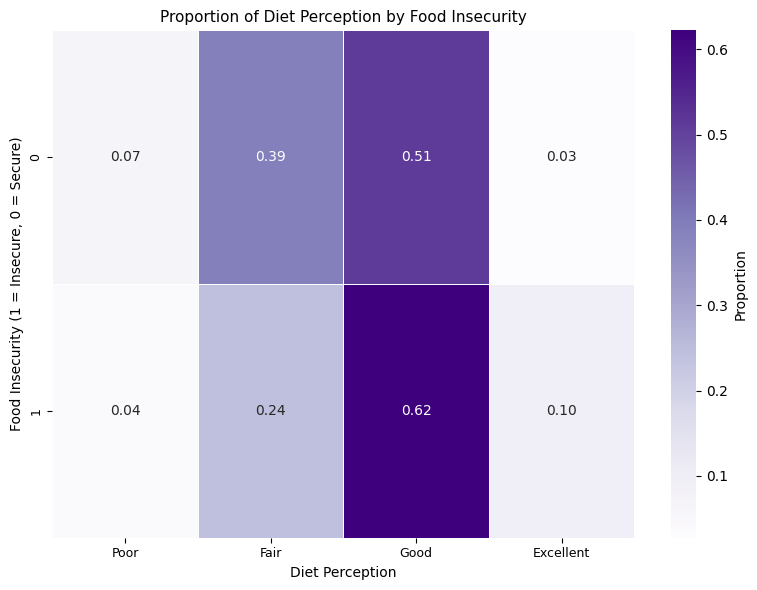

In [19]:
category_orders = {'hh_diet_quality': ['Poor', 'Fair', 'Good', 'Excellent']}
for var, order in category_orders.items():
    faps_cleaned[var] = pd.Categorical(faps_cleaned[var], categories=order, ordered=True)
foodinsec_dietperc_crosstab = pd.crosstab(faps_cleaned['hh_food_secure'], faps_cleaned['hh_diet_quality'], normalize='index')

plt.figure(figsize=(8, 6))
sns.heatmap(
    foodinsec_dietperc_crosstab,
    annot=True,
    fmt=".2f",
    cmap='Purples',
    cbar_kws={'label': 'Proportion'},
    linewidths=0.5,
    linecolor='white')
plt.title("Proportion of Diet Perception by Food Insecurity", fontsize=11)
plt.xlabel("Diet Perception", fontsize=10)
plt.ylabel("Food Insecurity (1 = Insecure, 0 = Secure)", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig("results/faps_foodinsecure_dietperception_heatmap.png", dpi=300)
plt.show()

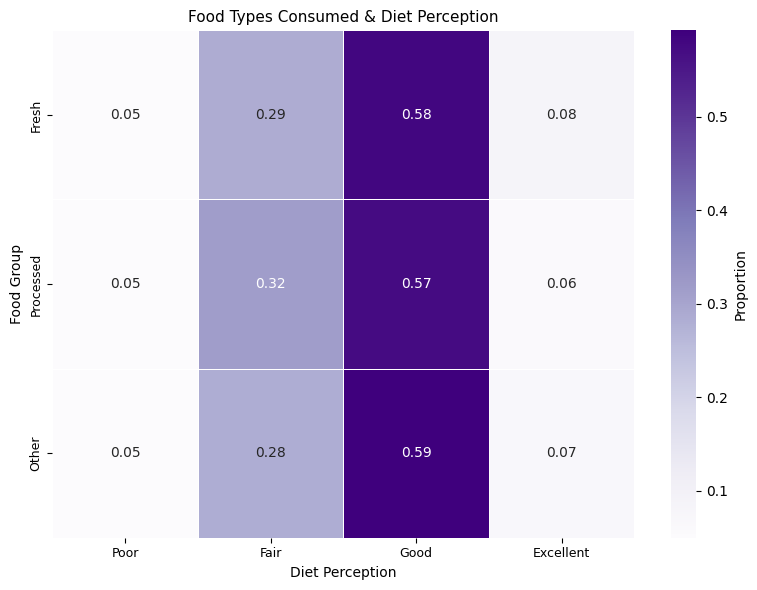

In [20]:
category_orders = {'food_type': ['Fresh', 'Processed', 'Other']}
for var, order in category_orders.items():
    faps_cleaned[var] = pd.Categorical(faps_cleaned[var], categories=order, ordered=True)
foodgroup_dietperc_crosstab = pd.crosstab(faps_cleaned['food_type'], faps_cleaned['hh_diet_quality'], normalize='index')
plt.figure(figsize=(8, 6))
sns.heatmap(foodgroup_dietperc_crosstab, annot=True, fmt=".2f", cmap='Purples', cbar_kws={'label': 'Proportion'}, linewidths=0.5, linecolor='white')
plt.title("Food Types Consumed & Diet Perception", fontsize=11)
plt.xlabel("Diet Perception", fontsize=10)
plt.ylabel("Food Group", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig("results/faps_foodgroup_dietperception_crosstab.png", dpi=300)
plt.show()

<Figure size 800x600 with 0 Axes>

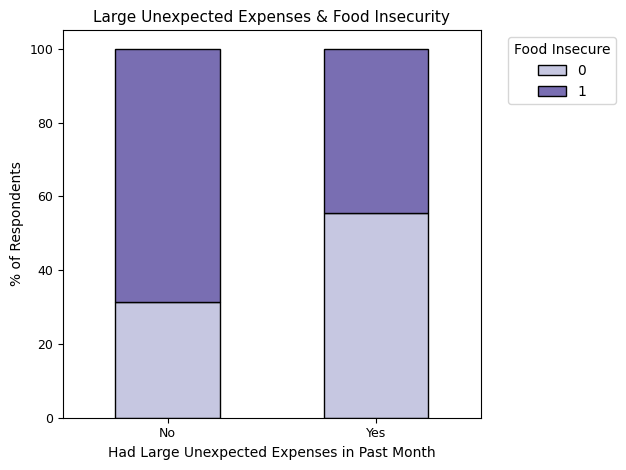

In [21]:
faps_cleaned_grouped = faps_cleaned.groupby(['large_expenditure_shock', 'hh_food_secure'], observed=True).size().unstack()
faps_cleaned_percent = faps_cleaned_grouped.div(faps_cleaned_grouped.sum(axis=1), axis=0) * 100
faps_cleaned_percent.index = faps_cleaned_percent.index.map({0: 'No', 1: 'Yes'})
purple_palette = sns.color_palette("Purples", n_colors=faps_cleaned_percent.shape[1])
plt.figure(figsize=(8, 6))
faps_cleaned_percent.plot(kind='bar', stacked=True, color=purple_palette, edgecolor='black')
plt.title("Large Unexpected Expenses & Food Insecurity", fontsize=11)
plt.xlabel("Had Large Unexpected Expenses in Past Month", fontsize=10)
plt.ylabel("% of Respondents", fontsize=10)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title="Food Insecure", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("results/faps_foodinsecure_largeexpenses.png", dpi=300)
plt.show()

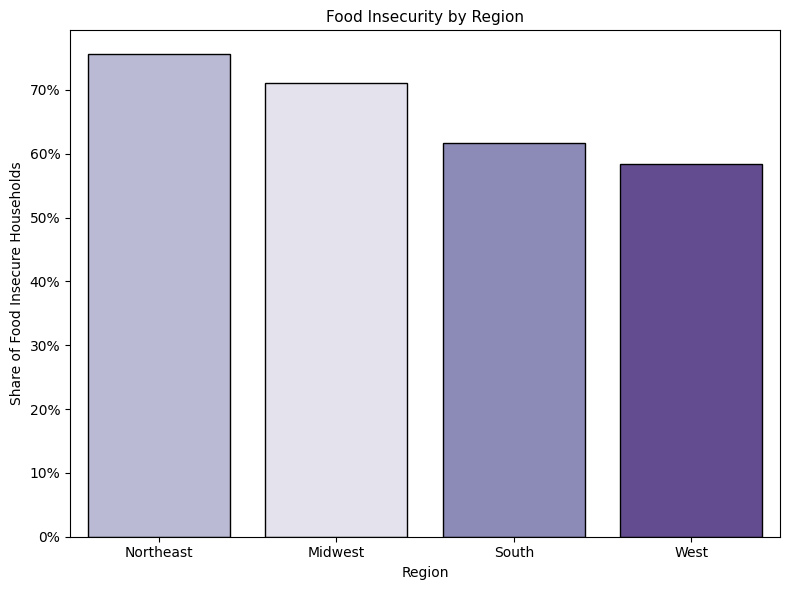

In [22]:
faps_cleaned['hh_food_secure'] = pd.to_numeric(faps_cleaned['hh_food_secure'], errors='coerce')
insecure_by_region = faps_cleaned.groupby('region')['hh_food_secure'].mean().reset_index()
purple_palette = sns.color_palette("Purples", n_colors=4)

plt.figure(figsize=(8, 6))
sns.barplot(data=insecure_by_region, x='region', y='hh_food_secure', hue='region', order=['Northeast', 'Midwest', 'South', 'West'], palette=purple_palette, edgecolor='black')
plt.ylabel("Share of Food Insecure Households", fontsize=10)
plt.xlabel("Region", fontsize=10)
plt.title("Food Insecurity by Region", fontsize=11)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.savefig("results/faps_foodinsecurity_region_bar.png", dpi=300)
plt.show()

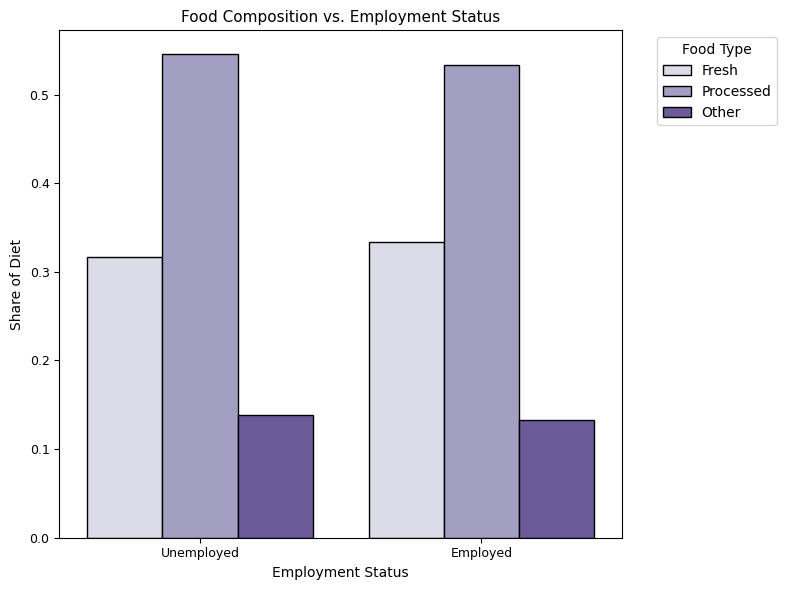

In [23]:
employment_foodtype_crosstab = pd.crosstab(faps_cleaned['employment'], faps_cleaned['food_type'], normalize='index').reset_index().melt(id_vars='employment', var_name='Food Type', value_name='Proportion')
purple_palette = sns.color_palette("Purples", n_colors=employment_foodtype_crosstab['Food Type'].nunique())

plt.figure(figsize=(8, 6))
sns.barplot(data=employment_foodtype_crosstab, x='employment', y='Proportion', hue='Food Type', palette=purple_palette, edgecolor='black')
plt.title("Food Composition vs. Employment Status", fontsize=11)
plt.xlabel("Employment Status", fontsize=10)
plt.ylabel("Share of Diet", fontsize=10)
plt.xticks([0, 1], ['Unemployed', 'Employed'], fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title='Food Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("results/faps_employment_foodtype.png", dpi=300)
plt.show()

In [24]:
# create composite "stress index"
stress_components = ['perceived_healthy_time', 'perceived_healthy_cost', 'hh_food_secure', 'large_expenditure_shock']
for col in stress_components:
    faps_cleaned[col] = pd.to_numeric(faps_cleaned[col], errors='coerce')
for col in stress_components:
    faps_cleaned[col + '_z'] = (faps_cleaned[col] - faps_cleaned[col].mean()) / faps_cleaned[col].std()
faps_cleaned['stress_index_standardized'] = faps_cleaned[[col + '_z' for col in stress_components]].sum(axis=1)
print(faps_cleaned[['stress_index_standardized'] + [col + '_z' for col in stress_components]].head())

   stress_index_standardized  perceived_healthy_time_z  \
0                  -0.416989                  2.220366   
1                  -0.416989                  2.220366   
2                  -0.416989                  2.220366   
3                  -0.416989                  2.220366   
4                  -0.416989                  2.220366   

   perceived_healthy_cost_z  hh_food_secure_z  large_expenditure_shock_z  
0                  -0.85919         -1.370193                  -0.407973  
1                  -0.85919         -1.370193                  -0.407973  
2                  -0.85919         -1.370193                  -0.407973  
3                  -0.85919         -1.370193                  -0.407973  
4                  -0.85919         -1.370193                  -0.407973  


In [25]:
print("Unique income values (sample):")
print(faps_cleaned['avg_hh_income'].dropna().unique()[:20])
print("\nIncome summary statistics:")
print(faps_cleaned['avg_hh_income'].describe())
zero_income_count = faps_cleaned[faps_cleaned['avg_hh_income'] == 0].shape[0]
print(f"\nNumber of households reporting zero income: {zero_income_count}")

Unique income values (sample):
[ 4667.33        1200.          5024.5         1800.
  3998.          7820.65184448  1500.          3263.338
  3033.33       15000.          2000.          5995.
  1377.          3025.4         8952.67        2822.
  6253.          4580.          1523.          3600.        ]

Income summary statistics:
count    342780.000000
mean       4543.002761
std        3996.963418
min           0.000000
25%        1888.000000
50%        3506.409840
75%        5713.768495
max       25650.000000
Name: avg_hh_income, dtype: float64

Number of households reporting zero income: 6100


/tmp/ipykernel_1256/2044798062.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=faps_cleaned, x='income_group', y='stress_index_standardized', palette=purple_palette, width=0.6, showcaps=True, fliersize=2, linewidth=1.2)


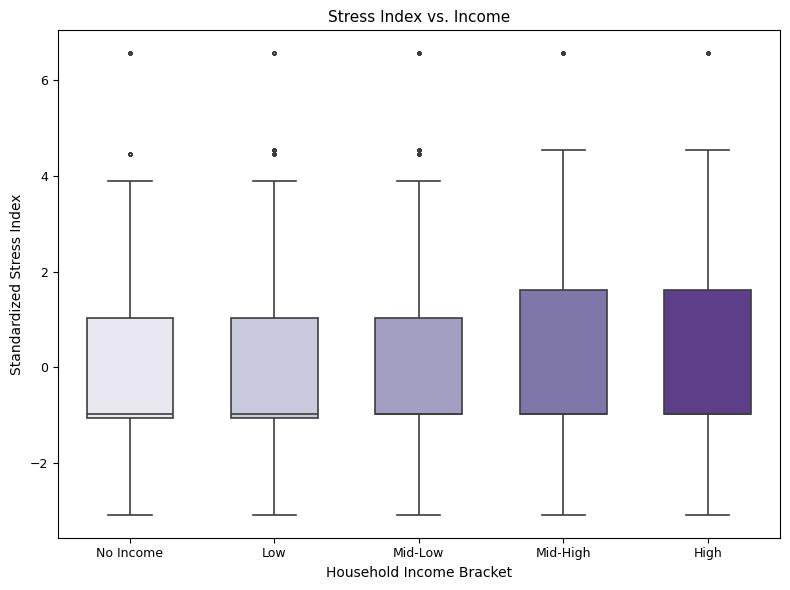

In [26]:
faps_cleaned['income_group'] = None
mask = faps_cleaned['avg_hh_income'] > 0
bins = pd.qcut(faps_cleaned.loc[mask, 'avg_hh_income'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])
faps_cleaned.loc[mask, 'income_group'] = bins
faps_cleaned.loc[faps_cleaned['avg_hh_income'] == 0, 'income_group'] = 'No Income'
order = ['No Income', 'Low', 'Mid-Low', 'Mid-High', 'High']
faps_cleaned['income_group'] = pd.Categorical(faps_cleaned['income_group'], categories=order, ordered=True)
purple_palette = sns.color_palette("Purples", n_colors=5)

plt.figure(figsize=(8, 6))
sns.boxplot(data=faps_cleaned, x='income_group', y='stress_index_standardized', palette=purple_palette, width=0.6, showcaps=True, fliersize=2, linewidth=1.2)
plt.title("Stress Index vs. Income", fontsize=11)
plt.xlabel("Household Income Bracket", fontsize=10)
plt.ylabel("Standardized Stress Index", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig("results/faps_stressindex_income.png", dpi=300)
plt.show()

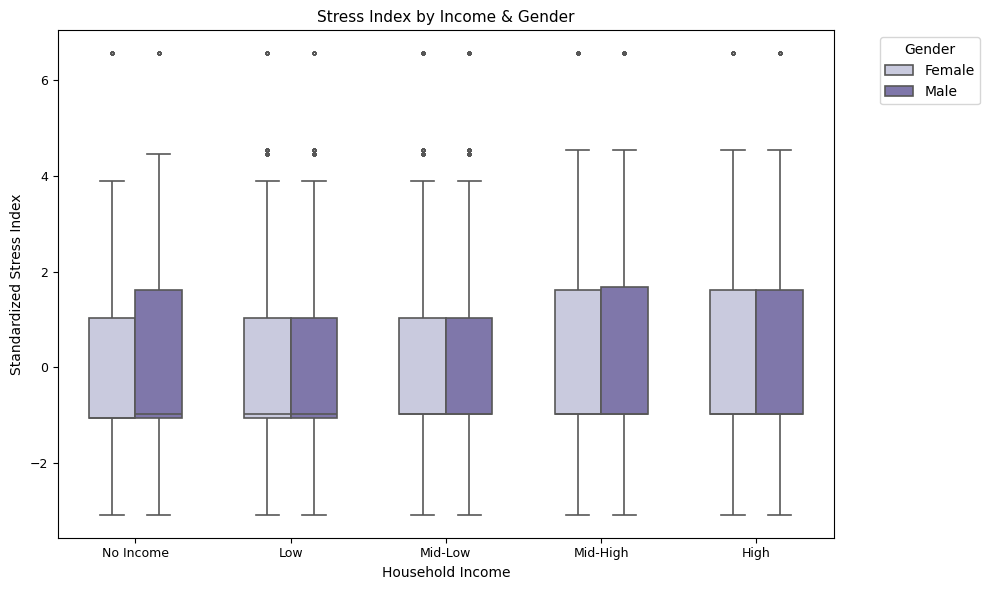

In [27]:
faps_cleaned['sex_label'] = faps_cleaned['sex'].map({0: 'Female', 1: 'Male'})
purple_palette = sns.color_palette("Purples", n_colors=2)

plt.figure(figsize=(10, 6))
sns.boxplot(data=faps_cleaned, x='income_group', y='stress_index_standardized', hue='sex_label', palette=purple_palette, width=0.6, fliersize=2, linewidth=1.2)
plt.title("Stress Index by Income & Gender", fontsize=11)
plt.xlabel("Household Income", fontsize=10)
plt.ylabel("Standardized Stress Index", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("results/faps_stressindex_income_gender.png", dpi=300)
plt.show()

/tmp/ipykernel_1256/4193654586.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=faps_cleaned, x='food_type', y='stress_index_standardized', order=['Fresh', 'Processed', 'Other'], palette=purple_palette, width=0.6, fliersize=2, linewidth=1.2)


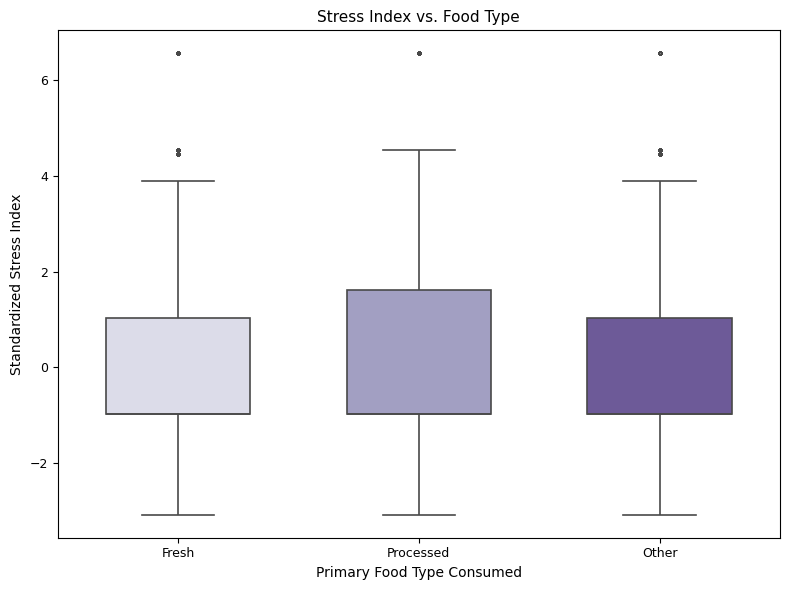

In [28]:
purple_palette = sns.color_palette("Purples", n_colors=3)

plt.figure(figsize=(8, 6))
sns.boxplot(data=faps_cleaned, x='food_type', y='stress_index_standardized', order=['Fresh', 'Processed', 'Other'], palette=purple_palette, width=0.6, fliersize=2, linewidth=1.2)
plt.title("Stress Index vs. Food Type", fontsize=11)
plt.xlabel("Primary Food Type Consumed", fontsize=10)
plt.ylabel("Standardized Stress Index", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig("results/faps_stressindex_foodtype.png", dpi=300)
plt.show()

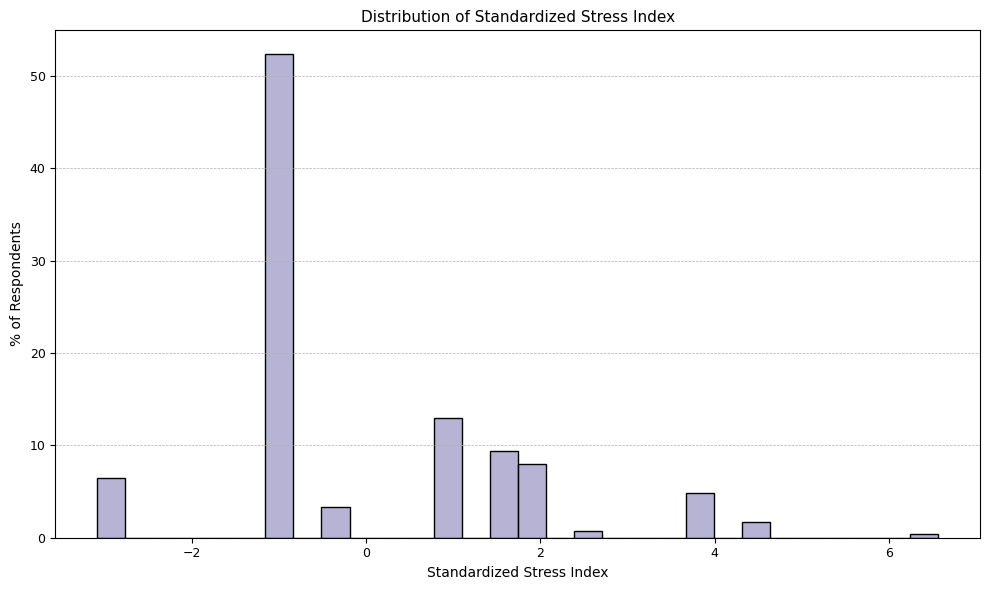

In [29]:
purple_hist = sns.color_palette("Purples", n_colors=1)

plt.figure(figsize=(10, 6))
sns.histplot(faps_cleaned['stress_index_standardized'].dropna(), bins=30, kde=False, stat='percent', edgecolor='black', color=purple_hist[0])
plt.title("Distribution of Standardized Stress Index", fontsize=11)
plt.xlabel("Standardized Stress Index", fontsize=10)
plt.ylabel("% of Respondents", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("results/faps_stressindex_distribution.png", dpi=300)
plt.show()

In [30]:
print(f"Dataset shape: {faps_cleaned.shape}")
for col in faps_cleaned.columns:
    print(f"\n--- {col} ({faps_cleaned[col].dtype}) ---")
    if faps_cleaned[col].dtype == 'object' or faps_cleaned[col].dtype.name == 'category':
        print(faps_cleaned[col].value_counts(dropna=False))
    else:
        print(faps_cleaned[col].describe().round(2))

Dataset shape: (342780, 49)

--- bmi (object) ---
bmi
Healthy       116535
Overweight    110943
Obese         109765
nan             5537
Name: count, dtype: int64

--- self_rated_health (category) ---
self_rated_health
Good         135208
Very Good     85317
Fair          61185
Excellent     45880
Poor          14927
NaN             263
Name: count, dtype: int64

--- dinners_out_per_week (object) ---
dinners_out_per_week
Sometimes    159882
Never        120908
Often         60071
NaN            1919
Name: count, dtype: int64

--- employment (category) ---
employment
1    178046
0    164734
Name: count, dtype: int64

--- race (object) ---
race
White                                           244343
Black                                            40247
Other                                            40144
Asian/Native Hawaiian/Other Pacific Islander     13877
American Indian/Alaska Native                     3805
NaN                                                364
Name: count, dtype

In [31]:
faps_cleaned['processed_dummy'] = (faps_cleaned['food_type'] == 'Processed').astype(int)
faps_cleaned['garden_ownership'] = faps_cleaned['garden_ownership'].astype(int)
hh_aggregated = faps_cleaned.groupby('hh_id').agg({
    'processed_dummy': 'mean',
    'stress_index_standardized': 'mean',
    'hh_size': 'first',
    'region': 'first',
    'food_group': 'mean',
    'perceived_healthy_cost': 'mean',
    'perceived_healthy_time': 'mean',
    'large_expenditure_shock': 'mean',
    'garden_ownership': 'sum'}).reset_index()
hh_aggregated.rename(columns={'processed_dummy': 'processed_prop'}, inplace=True)
print("Descriptive Statistics for Household-Level Variables:")
print(hh_aggregated[['processed_prop', 'stress_index_standardized', 'hh_size']].describe().round(2))

Descriptive Statistics for Household-Level Variables:
       processed_prop  stress_index_standardized
count         4352.00                    4352.00
mean             0.54                       0.06
std              0.21                       1.80
min              0.00                      -3.09
25%              0.40                      -0.99
50%              0.54                      -0.99
75%              0.68                       1.61
max              1.00                       6.57


/tmp/ipykernel_1256/3947588771.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1256/3947588771.py:2: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(


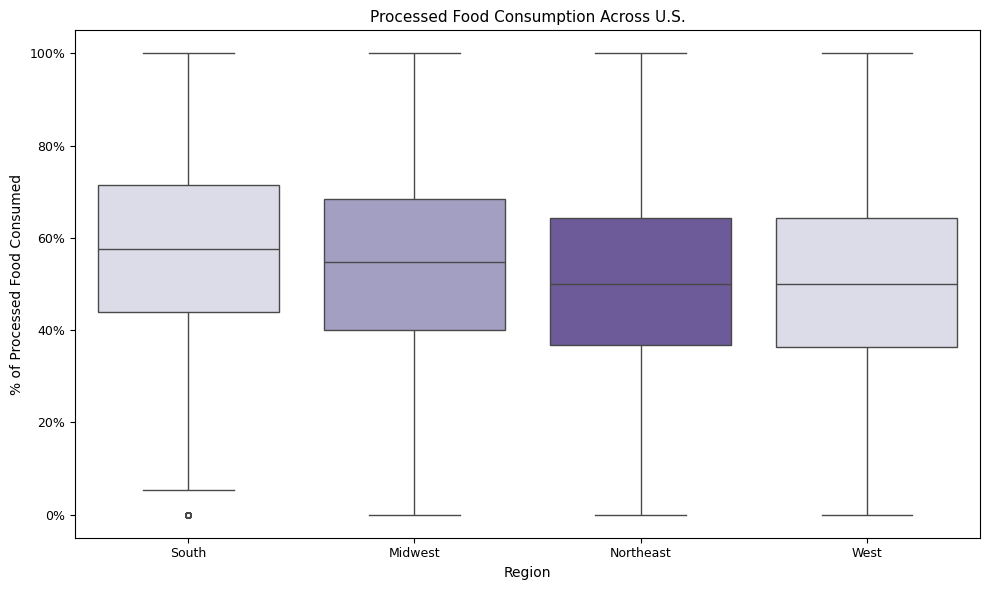

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=hh_aggregated,
    x='region',
    y='processed_prop',
    palette=purple_palette,
    showcaps=True,
    flierprops=dict(marker='o', markersize=4),
    linewidth=1)
plt.title('Processed Food Consumption Across U.S.', fontsize=11)
plt.xlabel('Region', fontsize=10)
plt.ylabel('% of Processed Food Consumed', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.savefig("results/faps_processed_region.png", dpi=300)
plt.show()

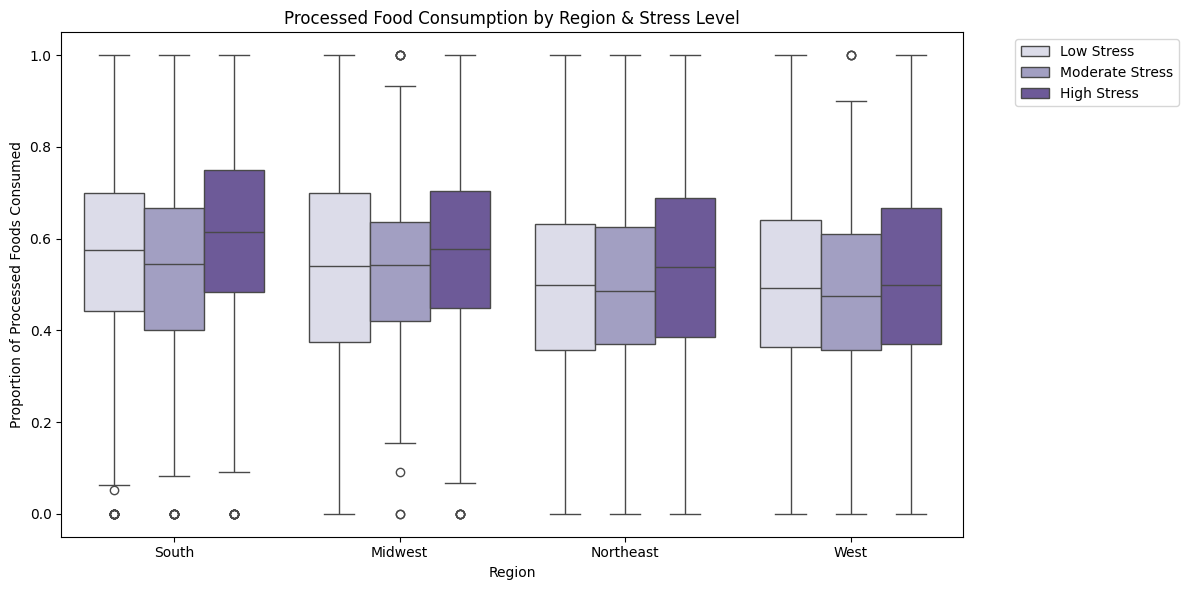

In [33]:
hh_aggregated['stress_group'] = pd.qcut(
    hh_aggregated['stress_index_standardized'],
    q=3,
    labels=['Low Stress', 'Moderate Stress', 'High Stress'])
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='region',
    y='processed_prop',
    hue='stress_group',
    data=hh_aggregated,
    palette=purple_palette[:3])
plt.title('Processed Food Consumption by Region & Stress Level')
plt.xlabel('Region')
plt.ylabel('Proportion of Processed Foods Consumed')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('results/faps_processed_region_stress.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
hh_aggregated['hh_size'] = pd.Categorical(
    hh_aggregated['hh_size'],
    categories=['Small Family', 'Individual', 'Big Family', 'Large Family'],
    ordered=False)
hh_aggregated['high_processed'] = (hh_aggregated['processed_prop'] > 0.5).astype(int)
print(hh_aggregated.columns)

Index(['hh_id', 'processed_prop', 'stress_index_standardized', 'hh_size',
       'region', 'food_group', 'perceived_healthy_cost',
       'perceived_healthy_time', 'large_expenditure_shock', 'garden_ownership',
       'stress_group', 'high_processed'],
      dtype='object')


In [35]:
hh_aggregated['hh_size'] = pd.Categorical(
    hh_aggregated['hh_size'],
    categories=['Individual', 'Small Family', 'Big Family', 'Large Family'],
    ordered=True)
hh_aggregated['high_processed'] = (hh_aggregated['processed_prop'] > 0.5).astype(int)
print("Household-level columns:")
print(hh_aggregated.columns.tolist())
print(hh_aggregated['hh_size'].value_counts())

Household-level columns:
['hh_id', 'processed_prop', 'stress_index_standardized', 'hh_size', 'region', 'food_group', 'perceived_healthy_cost', 'perceived_healthy_time', 'large_expenditure_shock', 'garden_ownership', 'stress_group', 'high_processed']
hh_size
Small Family    2702
Individual       878
Big Family       609
Large Family     163
Name: count, dtype: int64


/tmp/ipykernel_1256/63441057.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


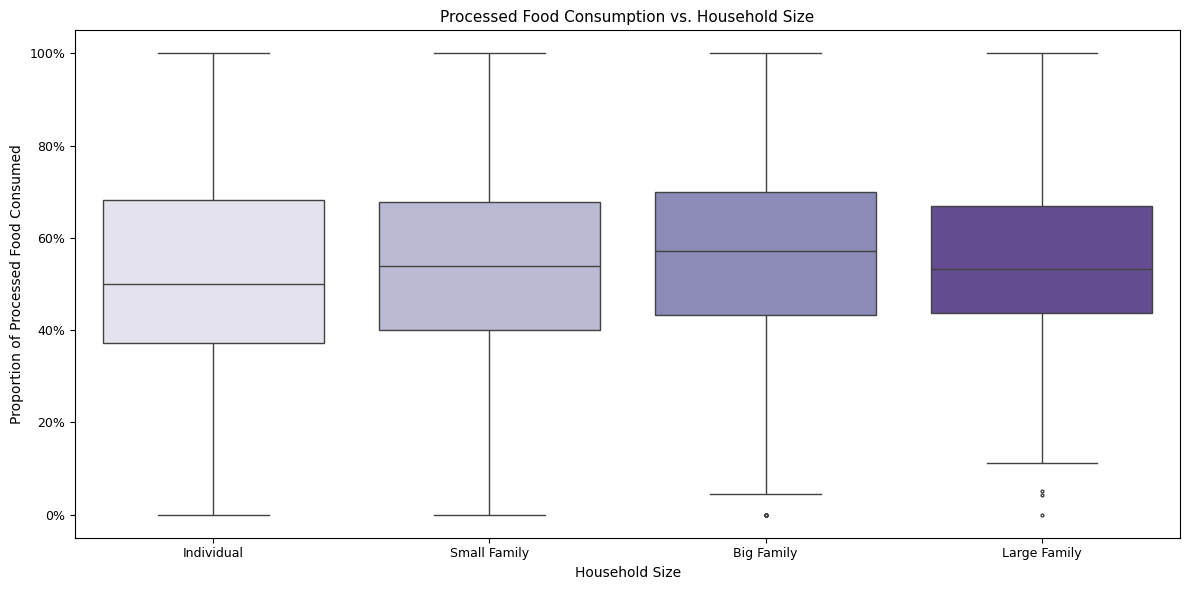

In [36]:
num_sizes = hh_aggregated['hh_size'].nunique()
palette_extended = sns.color_palette("Purples", num_sizes)

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='hh_size',
    y='processed_prop',
    data=hh_aggregated,
    palette=palette_extended,
    linewidth=1,
    fliersize=2)
plt.title('Processed Food Consumption vs. Household Size', fontsize=11)
plt.xlabel('Household Size', fontsize=10)
plt.ylabel('Proportion of Processed Food Consumed', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.savefig('results/faps_processed_hhsize.png', dpi=300)
plt.show()

In [37]:
import statsmodels.formula.api as sm
from statsmodels.iolib.summary2 import summary_col
model_1 = sm.logit(
    formula='high_processed ~ stress_index_standardized + hh_size + region + garden_ownership',
    data=hh_aggregated).fit()
print(model_1.summary())

Optimization terminated successfully.
         Current function value: 0.673439
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         high_processed   No. Observations:                 4352
Model:                          Logit   Df Residuals:                     4343
Method:                           MLE   Df Model:                            8
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.02052
Time:                        03:09:23   Log-Likelihood:                -2930.8
converged:                       True   LL-Null:                       -2992.2
Covariance Type:            nonrobust   LLR p-value:                 8.638e-23
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0718      0.085      0.841      0.400      -0.

In [38]:
marg_eff_1 = model_1.get_margeff(at='overall', method='dydx')
print(marg_eff_1.summary())

        Logit Marginal Effects       
Dep. Variable:         high_processed
Method:                          dydx
At:                           overall
                               dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
hh_size[T.Small Family]       0.0566      0.019      2.977      0.003       0.019       0.094
hh_size[T.Big Family]         0.1376      0.026      5.229      0.000       0.086       0.189
hh_size[T.Large Family]       0.1207      0.043      2.800      0.005       0.036       0.205
region[T.Northeast]          -0.1069      0.023     -4.631      0.000      -0.152      -0.062
region[T.South]               0.0535      0.020      2.741      0.006       0.015       0.092
region[T.West]               -0.1086      0.021     -5.063      0.000      -0.151      -0.067
stress_index_standardized     0.0076      0.004      1.821      0.069      -0.001       0.016
ga

/tmp/ipykernel_1256/80537783.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


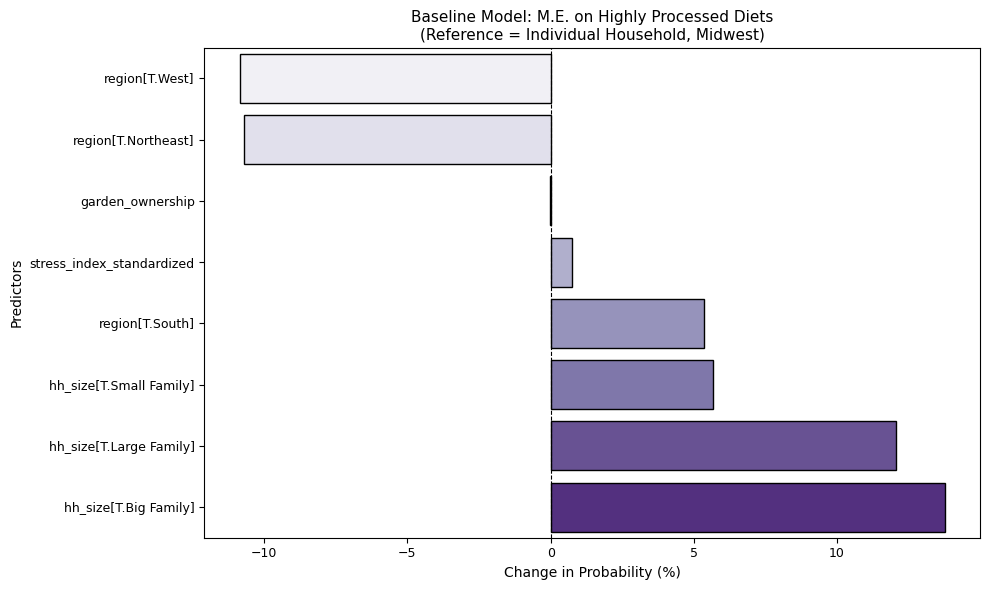

In [39]:
marg_eff_1 = model_1.get_margeff(at='overall', method='dydx')
marg_summary_df = marg_eff_1.summary_frame()
marg_summary_df = marg_summary_df.reset_index().rename(columns={'index': 'Variable'})
marg_summary_df['dy/dx'] = marg_summary_df['dy/dx'] * 100
marg_summary_df_rounded = marg_summary_df.round(3)
marg_summary_df_rounded = marg_summary_df_rounded.sort_values(by='dy/dx')

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=marg_summary_df_rounded,
    x='dy/dx',
    y='Variable',
    palette='Purples',
    orient='h',
    edgecolor='black')
plt.axvline(0, color='black', linestyle='dashed', linewidth=0.8)
plt.title("Baseline Model: M.E. on Highly Processed Diets\n(Reference = Individual Household, Midwest)", fontsize=11)
plt.xlabel("Change in Probability (%)", fontsize=10)
plt.ylabel("Predictors", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig("results/faps_marginal_effects_1.png", dpi=300)
plt.show()

In [40]:
model_2 = sm.logit(
    formula='high_processed ~ stress_index_standardized * hh_size + region + garden_ownership',
    data=hh_aggregated).fit()
print(model_2.summary())

Optimization terminated successfully.
         Current function value: 0.673317
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         high_processed   No. Observations:                 4352
Model:                          Logit   Df Residuals:                     4340
Method:                           MLE   Df Model:                           11
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.02070
Time:                        03:09:24   Log-Likelihood:                -2930.3
converged:                       True   LL-Null:                       -2992.2
Covariance Type:            nonrobust   LLR p-value:                 2.991e-21
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                     

In [41]:
model_3 = sm.logit(
    formula='high_processed ~ perceived_healthy_cost + perceived_healthy_time + large_expenditure_shock + hh_size + region + garden_ownership',
    data=hh_aggregated).fit()
print(model_3.summary())

Optimization terminated successfully.
         Current function value: 0.670168
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         high_processed   No. Observations:                 4352
Model:                          Logit   Df Residuals:                     4341
Method:                           MLE   Df Model:                           10
Date:                Wed, 23 Apr 2025   Pseudo R-squ.:                 0.02528
Time:                        03:09:24   Log-Likelihood:                -2916.6
converged:                       True   LL-Null:                       -2992.2
Covariance Type:            nonrobust   LLR p-value:                 2.016e-27
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0694      0.089     -0.776      0.438      -0.245   

/tmp/ipykernel_1256/3916975404.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


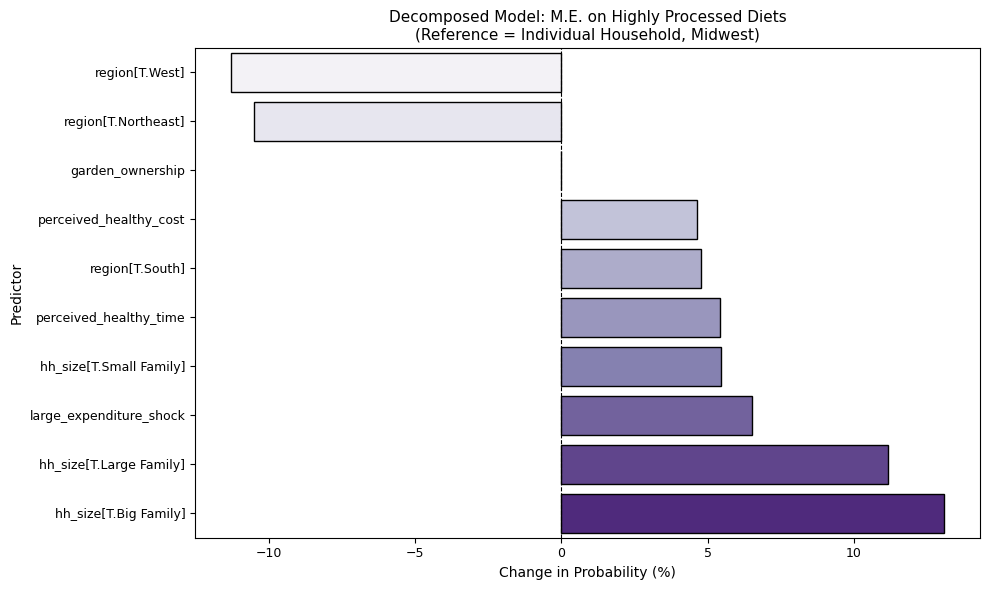

In [42]:
marg_eff_3 = model_3.get_margeff(at='overall', method='dydx')
me_df_3 = marg_eff_3.summary_frame().reset_index().rename(columns={'index': 'Variable'})
me_df_3['dy/dx'] = me_df_3['dy/dx'] * 100
me_df_3_rounded = me_df_3.round(3).sort_values(by='dy/dx')
plt.figure(figsize=(10, 6))
sns.barplot(
    data=me_df_3_rounded,
    x='dy/dx',
    y='Variable',
    palette='Purples',
    orient='h',
    edgecolor='black')
plt.axvline(0, color='black', linestyle='dashed', linewidth=0.8)
plt.title("Decomposed Model: M.E. on Highly Processed Diets\n(Reference = Individual Household, Midwest)", fontsize=11)
plt.xlabel("Change in Probability (%)", fontsize=10)
plt.ylabel("Predictor", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig("results/faps_marginal_effects_3.png", dpi=300)
plt.show()

In [43]:
summary = summary_col(
    [model_1, model_2, model_3],
    stars=True,
    float_format="%.3f",
    model_names=["Baseline", "Interaction", "Decomposed"],
    info_dict={
        'N': lambda x: f"{int(x.nobs)}",
        'Pseudo R²': lambda x: f"{x.prsquared:.3f}"},
    regressor_order=[
        'Intercept',
        'hh_size[T.Small Family]',
        'hh_size[T.Big Family]',
        'hh_size[T.Large Family]',
        'region[T.Northeast]',
        'region[T.South]',
        'region[T.West]',
        'stress_index_standardized',
        'garden_ownership',
        'stress_index_standardized:hh_size[T.Small Family]',
        'stress_index_standardized:hh_size[T.Big Family]',
        'stress_index_standardized:hh_size[T.Large Family]',
        'perceived_healthy_cost',
        'perceived_healthy_time',
        'large_expenditure_shock'])
with open("results/faps_logit_model_comparison.tex", "w") as f:
    f.write(summary.as_latex())

# **MEPS: data cleaning + processing**

In [44]:
meps = pd.read_csv("data/raw/meps_ipums_extract.csv")

pd.set_option("display.max_rows", None)
unique_counts = meps.nunique()
print(unique_counts)
pd.reset_option("display.max_rows")

columns_to_keep = [
    "DUID", "PID_1", "MEPSID", "SEX", "RELATE_1", "RACEA_1", "INCTOT_1", "FTOTVAL_1", 
    "HEALTH_1", "BMIKID_1", "MEPSIDRD", "RUSIZERD_1_1", "FAMSZERD_1_1", "REGMEPSRD_1_1", 
    "AGERD_1_1", "MOMPIDRD_1_1", "POPPIDRD_1_1", "EMPSTATRD_1_1", "HOURWRKRD_1_1", 
    "CLASSWK2RD_1_1", "INDCATRD_1_1", "OCCCATRD_1_1", "EHIOFFRRD_1_1"]
meps_cleaned = meps[columns_to_keep]
meps_cleaned = meps_cleaned[meps_cleaned['SEX'].isin([1, 2])]
meps_cleaned = meps_cleaned[meps_cleaned['RELATE_1'].isin([10, 20, 40, 71, 81])]
meps_cleaned = meps_cleaned[meps_cleaned['RACEA_1'].isin([100, 200, 300, 310, 320, 330, 340, 350, 400, 410, 411, 412, 413, 414, 415, 416, 420, 421, 422, 423])]
meps_cleaned = meps_cleaned[meps_cleaned['HEALTH_1'].isin([1, 2, 3, 4, 5])]
meps_cleaned = meps_cleaned[meps_cleaned['REGMEPSRD_1_1'] != 0]
meps_cleaned.to_csv('data/derived/meps_cleaned.csv', index=False)

YEAR_1                1
YEAR_2                1
DUID              12884
PID_1                27
PID_2                33
MEPSID            34655
SEX                   2
RELATE_1             13
RELATE_2             12
RACEA_1              13
RACEA_2              13
EDUC_1               25
EDUC_2               25
INCTOT_1           5283
INCTOT_2           5436
FTOTVAL_1          4315
FTOTVAL_2          4419
HEALTH_1              7
HEALTH_2              7
BMIKID_1            291
BMIKID_2            298
MEPSIDRD          34655
RUSIZERD_1_1         13
RUSIZERD_1_2         13
RUSIZERD_1_3         12
RUSIZERD_2_3         13
RUSIZERD_2_4         12
RUSIZERD_2_5         13
FAMSZERD_1_1         13
FAMSZERD_1_2         13
FAMSZERD_1_3         12
FAMSZERD_2_3         13
FAMSZERD_2_4         12
FAMSZERD_2_5         13
REGMEPSRD_1_1         5
REGMEPSRD_1_2         5
REGMEPSRD_1_3         5
REGMEPSRD_2_3         5
REGMEPSRD_2_4         5
REGMEPSRD_2_5         5
AGERD_1_1            87
AGERD_1_2       

In [45]:
print(f"Final MEPS cleaned shape: {meps_cleaned.shape}")

Final MEPS cleaned shape: (9521, 23)


In [46]:
meps_cleaned['sex'] = meps_cleaned['SEX'].replace({1: 'Male', 2: 'Female'})
meps_cleaned['relationship'] = meps_cleaned['RELATE_1'].replace({
    10: 'Self', 20: 'Spouse', 40: 'Child', 71: 'Other relative', 81: 'Non-relative'
})
meps_cleaned['race'] = meps_cleaned['RACEA_1'].replace({
    100: 'White', 200: 'Black', 300: 'Asian', 310: 'Asian Indian', 320: 'Chinese',
    330: 'Filipino', 340: 'Japanese', 350: 'Korean', 400: 'Vietnamese',
    410: 'Other Asian', 411: 'Native Hawaiian', 412: 'Guamanian',
    413: 'Samoan', 414: 'Other PI', 415: 'Multiple PI', 416: 'Other'
})
meps_cleaned['health_perception'] = meps_cleaned['HEALTH_1'].replace({
    1: 'Excellent', 2: 'Very Good', 3: 'Good', 4: 'Fair', 5: 'Poor'
})
meps_cleaned['region'] = meps_cleaned['REGMEPSRD_1_1'].replace({
    1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'
})
meps_cleaned['employment_status'] = meps_cleaned['EMPSTATRD_1_1'].replace({
    1: 'Employed', 2: 'Not Employed', 3: 'Unemployed', 4: 'Retired',
    5: 'Disabled', 6: 'Student', 7: 'Keeping House', 8: 'Other', 9: 'Unknown'
})
meps_cleaned['work_class'] = meps_cleaned['CLASSWK2RD_1_1'].replace({
    1: 'Private', 2: 'Federal Govt', 3: 'State Govt', 4: 'Local Govt',
    5: 'Self-incorporated', 6: 'Self-not-incorporated',
    7: 'Unpaid', 8: 'Other', 9: 'Unknown'
})
meps_cleaned['industry'] = meps_cleaned['INDCATRD_1_1'].replace({
    1: 'Agriculture', 2: 'Mining', 3: 'Construction', 4: 'Manufacturing',
    5: 'Wholesale', 6: 'Retail', 7: 'Transport', 8: 'Information',
    9: 'Finance', 10: 'Real Estate', 11: 'Professional Services',
    12: 'Education', 13: 'Healthcare', 14: 'Arts/Entertainment',
    15: 'Accommodation/Food', 16: 'Public Admin', 17: 'Other',
    18: 'Unknown'
})
meps_cleaned['occupation'] = meps_cleaned['OCCCATRD_1_1'].replace({
    1: 'Management', 2: 'Business', 3: 'Finance', 4: 'STEM',
    5: 'Engineering', 6: 'Science', 7: 'Social service', 8: 'Legal',
    9: 'Education', 10: 'Healthcare', 11: 'Protection', 12: 'Food service',
    13: 'Maintenance', 14: 'Other'
})
meps_cleaned['employer_insurance_offer'] = meps_cleaned['EHIOFFRRD_1_1'].replace({
    1: 'Yes', 2: 'No', 3: 'DK/Refused', 4: 'Not asked',
    5: 'Missing', 6: 'OOS', 7: 'Unknown'
})
meps_cleaned['age_group'] = pd.cut(
    meps_cleaned['AGERD_1_1'],
    bins=[0, 17, 29, 44, 64, 120],
    labels=['Child', 'Young Adult', 'Adult', 'Middle Aged', 'Senior']
)
meps_cleaned['bmi_category'] = pd.cut(
    meps_cleaned['BMIKID_1'],
    bins=[0, 18.5, 24.9, 29.9, 100],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)
meps_cleaned.to_csv('data/derived/meps_cleaned.csv', index=False)
meps_cleaned.head()

,DUID,PID_1,MEPSID,SEX,RELATE_1,RACEA_1,INCTOT_1,FTOTVAL_1,HEALTH_1,BMIKID_1,...,race,health_perception,region,employment_status,work_class,industry,occupation,employer_insurance_offer,age_group,bmi_category
17603,10001,101.0,2110001101,2,10.0,100.0,82200.0,182202.0,1.0,0.0,...,White,Excellent,Northeast,Employed,State Govt,Real Estate,Business,No,Adult,NaN
17604,10001,102.0,2110001102,1,20.0,100.0,100002.0,182202.0,1.0,0.0,...,White,Excellent,Northeast,Employed,0.0,Information,STEM,Yes,Adult,NaN
17607,10002,101.0,2110002101,1,10.0,200.0,0.0,0.0,3.0,0.0,...,Black,Good,Northeast,Retired,0.0,0.0,0.0,0.0,Senior,NaN
17608,10002,102.0,2110002102,1,40.0,200.0,0.0,0.0,1.0,0.0,...,Black,Excellent,Northeast,Retired,0.0,0.0,0.0,0.0,Young Adult,NaN
17609,10004,101.0,2110004101,1,10.0,200.0,27994.0,27994.0,1.0,0.0,...,Black,Excellent,South,Employed,Private,Wholesale,Engineering,No,Adult,NaN


In [47]:
meps_cleaned = meps_cleaned.dropna(subset=['industry', 'occupation'])
meps_cleaned = meps_cleaned[(meps_cleaned['industry'] != 0.0) & (meps_cleaned['occupation'] != 0.0)]
meps_cleaned = meps_cleaned[meps_cleaned['employment_status'] == 'Employed']
meps_cleaned.to_csv('data/derived/meps_cleaned.csv', index=False)
meps_cleaned.head()

,DUID,PID_1,MEPSID,SEX,RELATE_1,RACEA_1,INCTOT_1,FTOTVAL_1,HEALTH_1,BMIKID_1,...,race,health_perception,region,employment_status,work_class,industry,occupation,employer_insurance_offer,age_group,bmi_category
17603,10001,101.0,2110001101,2,10.0,100.0,82200.0,182202.0,1.0,0.0,...,White,Excellent,Northeast,Employed,State Govt,Real Estate,Business,No,Adult,NaN
17604,10001,102.0,2110001102,1,20.0,100.0,100002.0,182202.0,1.0,0.0,...,White,Excellent,Northeast,Employed,0.0,Information,STEM,Yes,Adult,NaN
17609,10004,101.0,2110004101,1,10.0,200.0,27994.0,27994.0,1.0,0.0,...,Black,Excellent,South,Employed,Private,Wholesale,Engineering,No,Adult,NaN
17610,10005,101.0,2110005101,2,10.0,200.0,95586.0,215586.0,3.0,0.0,...,Black,Good,West,Employed,State Govt,Real Estate,Business,Yes,Senior,NaN
17611,10005,102.0,2110005102,2,40.0,200.0,120000.0,215586.0,4.0,0.0,...,Black,Fair,West,Employed,State Govt,Real Estate,Business,No,Adult,NaN


In [48]:
print(meps_cleaned.columns.tolist())

['DUID', 'PID_1', 'MEPSID', 'SEX', 'RELATE_1', 'RACEA_1', 'INCTOT_1', 'FTOTVAL_1', 'HEALTH_1', 'BMIKID_1', 'MEPSIDRD', 'RUSIZERD_1_1', 'FAMSZERD_1_1', 'REGMEPSRD_1_1', 'AGERD_1_1', 'MOMPIDRD_1_1', 'POPPIDRD_1_1', 'EMPSTATRD_1_1', 'HOURWRKRD_1_1', 'CLASSWK2RD_1_1', 'INDCATRD_1_1', 'OCCCATRD_1_1', 'EHIOFFRRD_1_1', 'sex', 'relationship', 'race', 'health_perception', 'region', 'employment_status', 'work_class', 'industry', 'occupation', 'employer_insurance_offer', 'age_group', 'bmi_category']


In [49]:
meps_cleaned = meps_cleaned.drop(columns=['bmi_category', 'BMIKID_1', 'PID_1', 'MEPSID', 'SEX', 'RELATE_1', 
                                          'RACEA_1', 'MEPSIDRD', 'RUSIZERD_1_1', 'FAMSZERD_1_1', 'REGMEPSRD_1_1', 
                                          'AGERD_1_1', 'MOMPIDRD_1_1', 'POPPIDRD_1_1', 'EMPSTATRD_1_1', 'CLASSWK2RD_1_1', 
                                          'INDCATRD_1_1', 'OCCCATRD_1_1', 'EHIOFFRRD_1_1', 'work_class', 'race'])
meps_cleaned = meps_cleaned.rename(columns={
    'INCTOT_1': 'total_income',
    'FTOTVAL_1': 'total_family_income',
    'HOURWRKRD_1_1': 'hours_worked'})
meps_cleaned = meps_cleaned[meps_cleaned['relationship'] != 'Other relative']
meps_cleaned = meps_cleaned[~meps_cleaned['industry'].isin(['90', '90.0', 90])]
meps_cleaned = meps_cleaned[~meps_cleaned['occupation'].isin(['90', '90.0', 90])]
meps_cleaned['occupation'] = meps_cleaned['occupation'].replace({'Science': 'STEM'})
invalid_values = ['0.0', '8.0', '9.0', 'Unknown']
meps_cleaned = meps_cleaned[~meps_cleaned['employer_insurance_offer'].isin(invalid_values)]
meps_cleaned.to_csv('data/derived/meps_cleaned.csv', index=False)
meps_cleaned.head()

,DUID,total_income,total_family_income,HEALTH_1,hours_worked,sex,relationship,health_perception,region,employment_status,industry,occupation,employer_insurance_offer,age_group
17603,10001,82200.0,182202.0,1.0,53.0,Female,Self,Excellent,Northeast,Employed,Real Estate,Business,No,Adult
17604,10001,100002.0,182202.0,1.0,55.0,Male,Spouse,Excellent,Northeast,Employed,Information,STEM,Yes,Adult
17609,10004,27994.0,27994.0,1.0,44.0,Male,Self,Excellent,South,Employed,Wholesale,Engineering,No,Adult
17610,10005,95586.0,215586.0,3.0,28.0,Female,Self,Good,West,Employed,Real Estate,Business,Yes,Senior
17611,10005,120000.0,215586.0,4.0,52.0,Female,Child,Fair,West,Employed,Real Estate,Business,No,Adult


In [50]:
print(meps_cleaned.isnull().sum())

DUID                        0
total_income                0
total_family_income         0
HEALTH_1                    0
hours_worked                0
sex                         0
relationship                0
health_perception           0
region                      0
employment_status           0
industry                    0
occupation                  0
employer_insurance_offer    0
age_group                   0
dtype: int64


# **MEPS: data analysis**

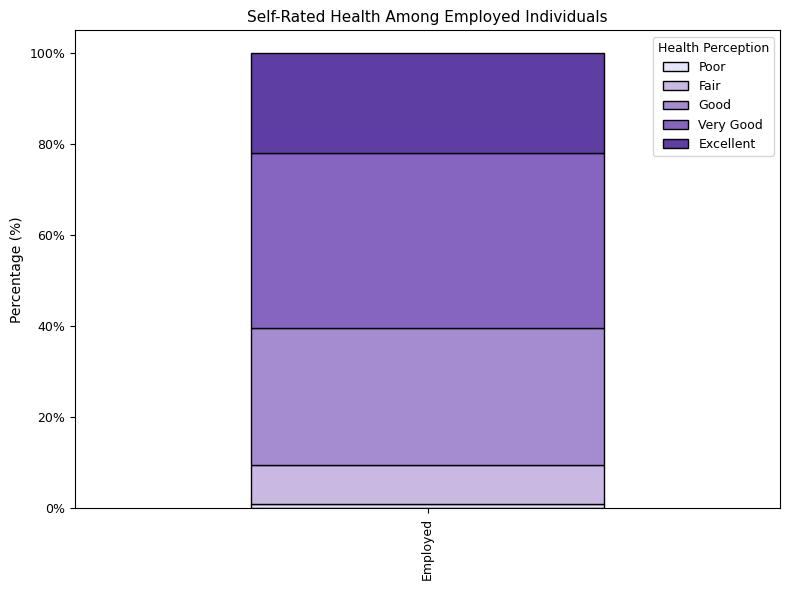

In [51]:
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

cool_purple_palette = ListedColormap(['#e6e6fa', '#c8b8e2', '#a58cd1', '#8665c1', '#5e3ea3']).colors

ct = pd.crosstab(meps_cleaned['employment_status'], meps_cleaned['health_perception'], normalize='index') * 100
ct = ct[['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']]

plt.figure(figsize=(8, 6))
ct.plot(kind='bar', stacked=True, edgecolor='black', color=cool_purple_palette, ax=plt.gca())
plt.title('Self-Rated Health Among Employed Individuals', fontsize=11)
plt.xlabel('')
plt.ylabel('Percentage (%)', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.legend(title='Health Perception', title_fontsize=9, fontsize=9)
plt.tight_layout()
plt.savefig('results/meps_employment_healthperception.png', dpi=300)
plt.show()

/tmp/ipykernel_1256/3918278008.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_1256/3918278008.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


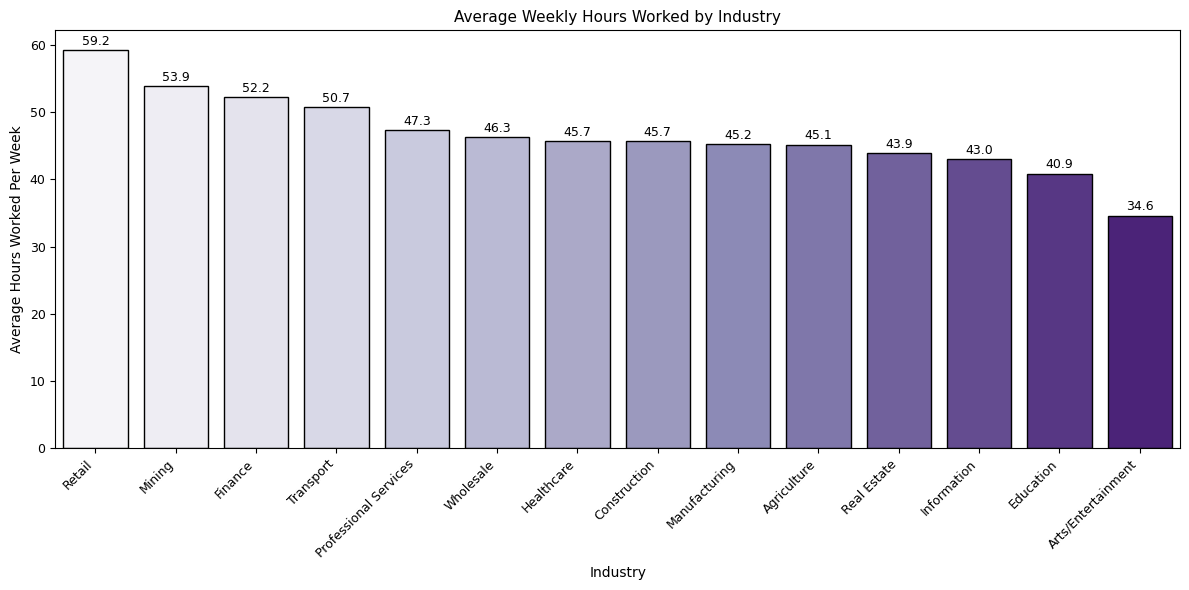

In [52]:
industry_order = meps_cleaned.groupby('industry')['hours_worked'].mean().sort_values(ascending=False).index
plt.figure(figsize=(12, 6))
sns.barplot(
    data=meps_cleaned,
    x='industry',
    y='hours_worked',
    estimator='mean',
    ci=None,
    order=industry_order,
    palette='Purples',
    edgecolor='black')
means = meps_cleaned.groupby('industry')['hours_worked'].mean().sort_values(ascending=False)
for i, val in enumerate(means):
    plt.text(i, val + 0.8, f'{val:.1f}', ha='center', fontsize=9)
plt.title('Average Weekly Hours Worked by Industry', fontsize=11)
plt.xlabel('Industry', fontsize=10)
plt.ylabel('Average Hours Worked Per Week', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig('results/meps_hours_industry.png', dpi=300)
plt.show()

/tmp/ipykernel_1256/2875517163.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_1256/2875517163.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


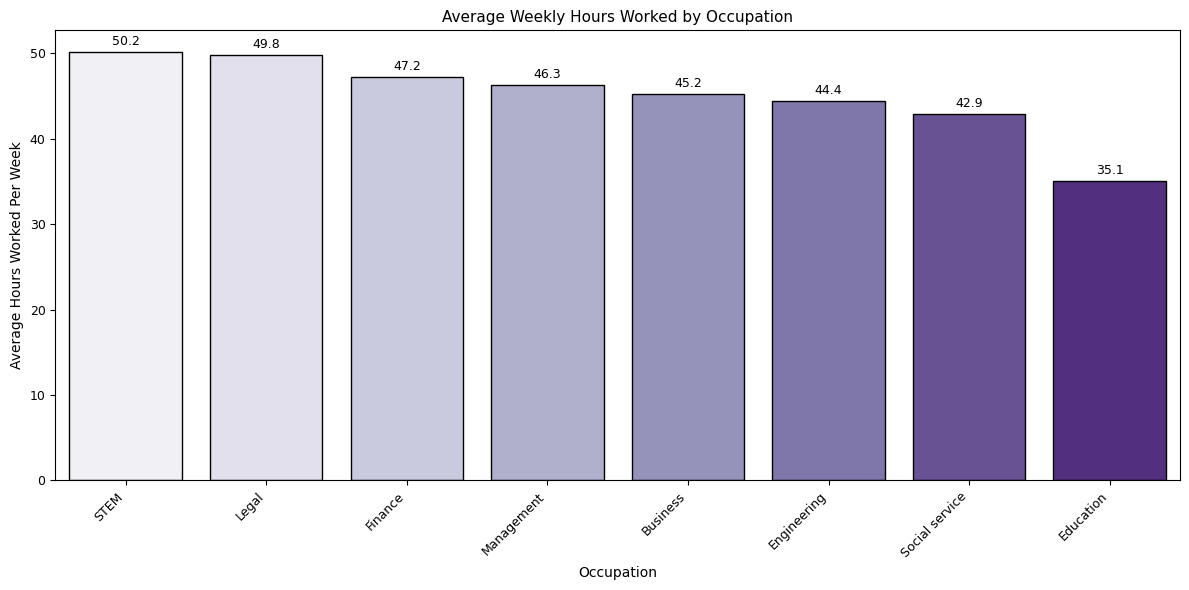

In [53]:
meps_cleaned = meps_cleaned[meps_cleaned['occupation'] != '90.0']
occupation_order = meps_cleaned.groupby('occupation')['hours_worked'].mean().sort_values(ascending=False).index
plt.figure(figsize=(12, 6))
sns.barplot(
    data=meps_cleaned,
    x='occupation',
    y='hours_worked',
    estimator='mean',
    order=occupation_order,
    ci=None,
    palette='Purples',
    edgecolor='black')
means = meps_cleaned.groupby('occupation')['hours_worked'].mean().sort_values(ascending=False)
for i, val in enumerate(means):
    plt.text(i, val + 0.8, f'{val:.1f}', ha='center', fontsize=9)
plt.title('Average Weekly Hours Worked by Occupation', fontsize=11)
plt.xlabel('Occupation', fontsize=10)
plt.ylabel('Average Hours Worked Per Week', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig('results/meps_hours_occupation.png', dpi=300)
plt.show()

/tmp/ipykernel_1256/1374315475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  meps_cleaned.groupby(['industry', 'income_group']).size()


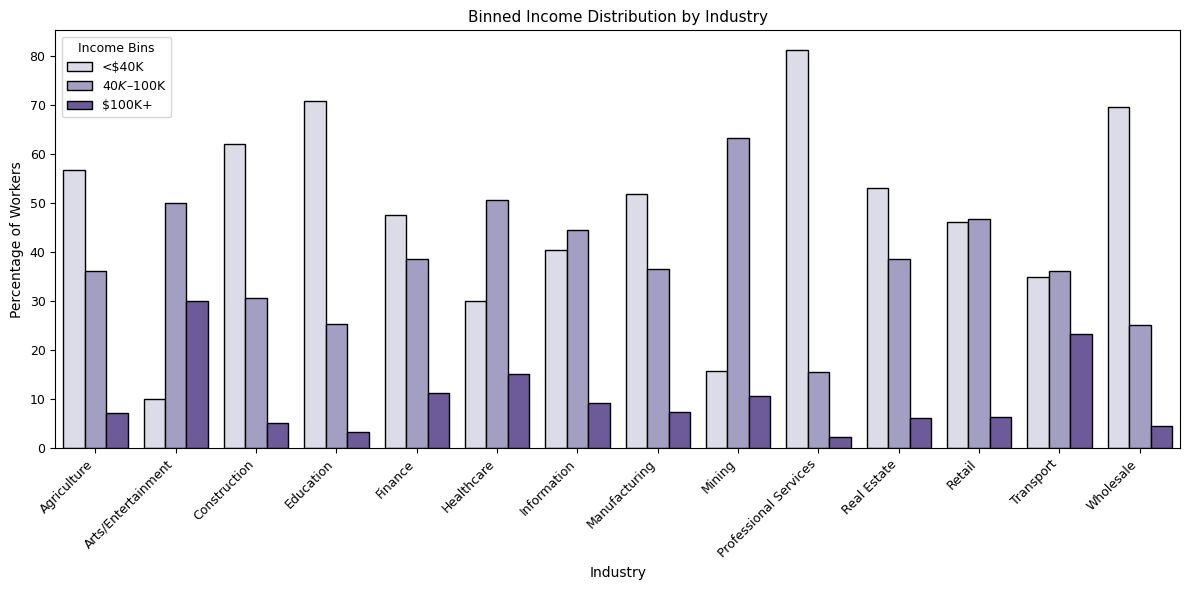

In [54]:
income_bins = [0, 40000, 100000, 200000]
income_labels = ['<$40K', '$40K–$100K', '$100K+']
meps_cleaned['income_group'] = pd.cut(
    meps_cleaned['total_income'], bins=income_bins, labels=income_labels, include_lowest=True)

industry_income_dist = (
    meps_cleaned.groupby(['industry', 'income_group']).size()
    .div(meps_cleaned.groupby('industry').size(), level='industry')
    .reset_index(name='proportion'))
industry_income_dist['Percentage'] = industry_income_dist['proportion'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(
    data=industry_income_dist,
    x='industry',
    y='Percentage',
    hue='income_group',
    palette=purple_palette[:3],
    edgecolor='black')
plt.title('Binned Income Distribution by Industry', fontsize=11)
plt.xlabel('Industry', fontsize=10)
plt.ylabel('Percentage of Workers', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title='Income Bins', title_fontsize=9, fontsize=9)
plt.tight_layout()
plt.savefig("results/meps_incomebins_industry.png", dpi=300)
plt.show()

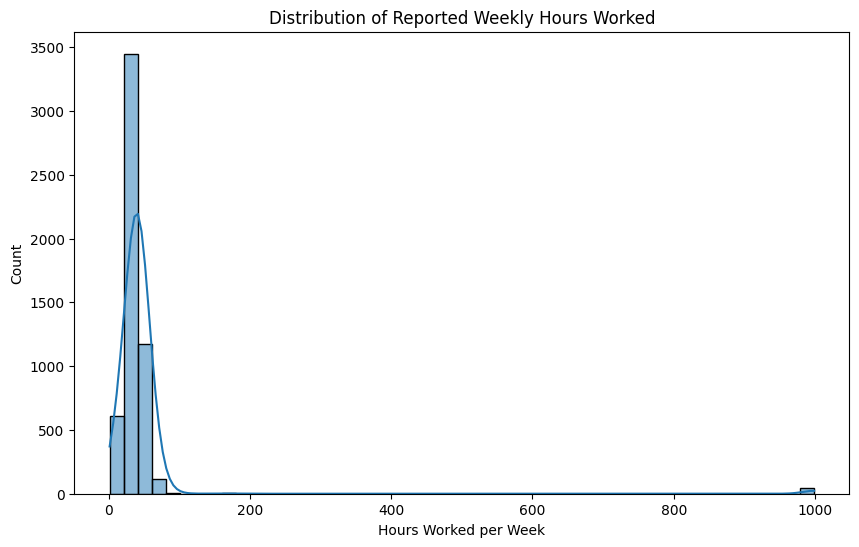

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(meps_cleaned['hours_worked'], bins=50, kde=True)
plt.title('Distribution of Reported Weekly Hours Worked')
plt.xlabel('Hours Worked per Week')
plt.show()

In [56]:
meps_cleaned = meps_cleaned[
    (meps_cleaned['hours_worked'] >= 1) &
    (meps_cleaned['hours_worked'] <= 168)]
busiest_occupation_industry_pairs = (
    meps_cleaned
    .groupby(['occupation', 'industry'])['hours_worked']
    .mean()
    .reset_index()
    .sort_values(by='hours_worked', ascending=False)
    .head(10))
busiest_occupation_industry_pairs['hours_worked'] = busiest_occupation_industry_pairs['hours_worked'].round(1)
print(busiest_occupation_industry_pairs)

        occupation               industry  hours_worked
59      Management                 Mining          72.6
46           Legal                 Mining          53.8
66            STEM           Construction          51.7
27         Finance            Agriculture          50.8
88  Social service              Transport          48.3
52      Management            Agriculture          47.4
60      Management  Professional Services          46.8
83  Social service          Manufacturing          46.3
39           Legal            Agriculture          45.6
77  Social service            Agriculture          45.0


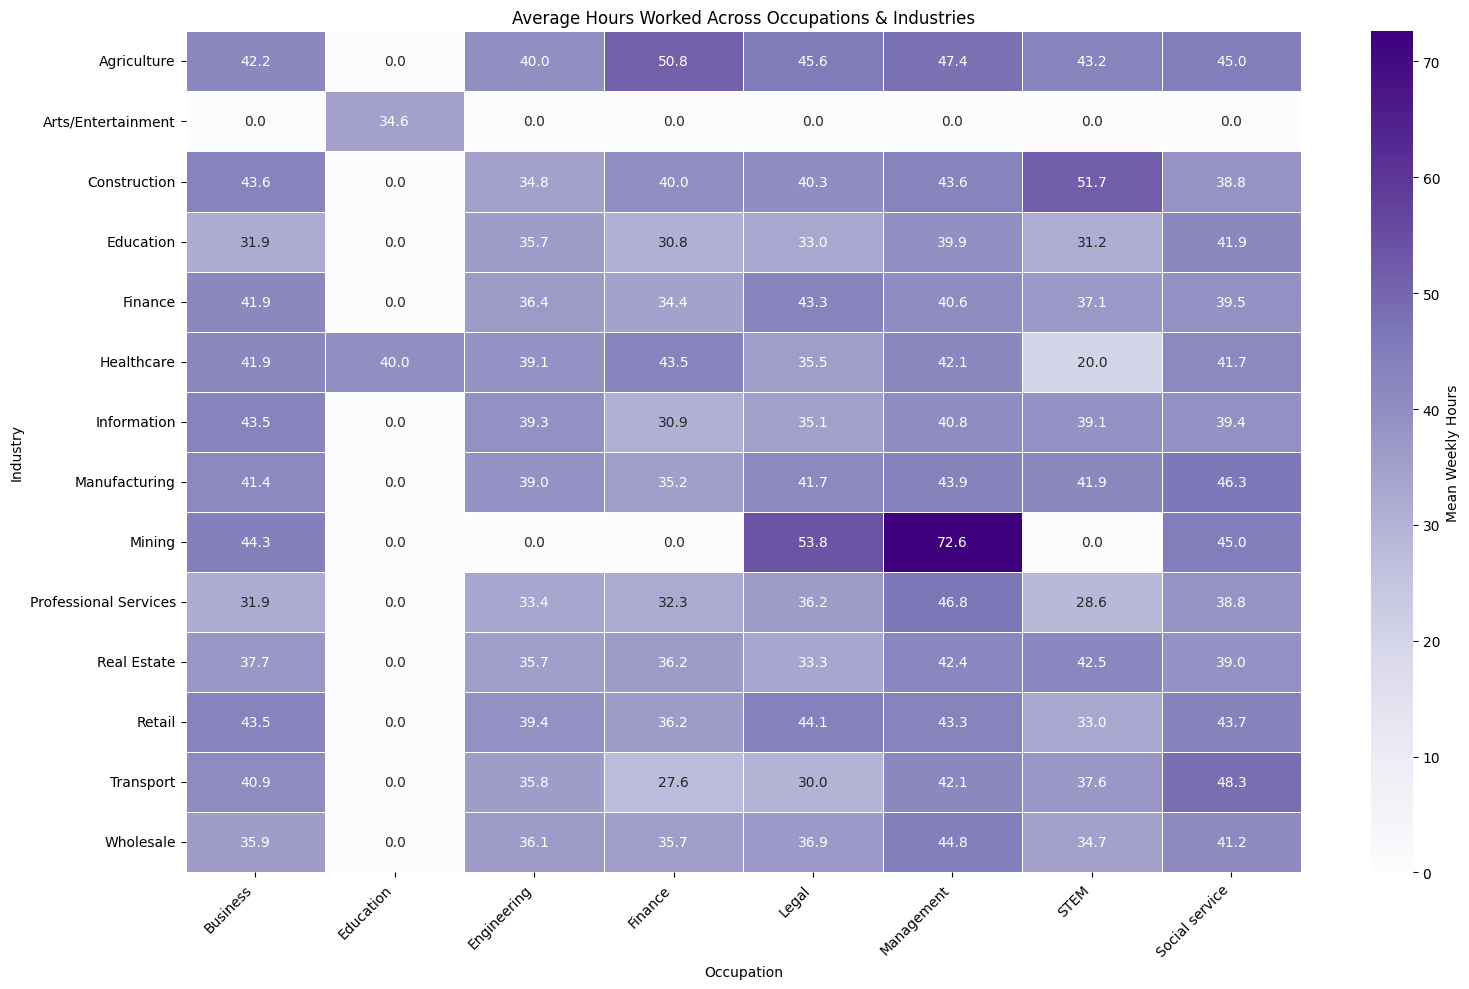

In [57]:
heatmap = meps_cleaned.pivot_table(
    index='industry',
    columns='occupation',
    values='hours_worked',
    aggfunc='mean',
    fill_value=0)
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap, annot=True, fmt='.1f', cmap='Purples', linewidths=0.5, cbar_kws={'label': 'Mean Weekly Hours'})
plt.title('Average Hours Worked Across Occupations & Industries')
plt.xlabel('Occupation')
plt.ylabel('Industry')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'results/meps_industry_occupation_heatmap.png', dpi=300)
plt.show()

In [58]:
from pandas.api.types import CategoricalDtype

health_order = CategoricalDtype(categories=["Fair", "Good", "Very Good", "Excellent"], ordered=True)
top_busiest_pairs = meps_cleaned.merge(
    busiest_occupation_industry_pairs[['occupation', 'industry']],
    on=['occupation', 'industry'],
    how='inner')
top_busiest_pairs['occupation_industry'] = top_busiest_pairs['occupation'] + " | " + top_busiest_pairs['industry']

/tmp/ipykernel_1256/3058519867.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


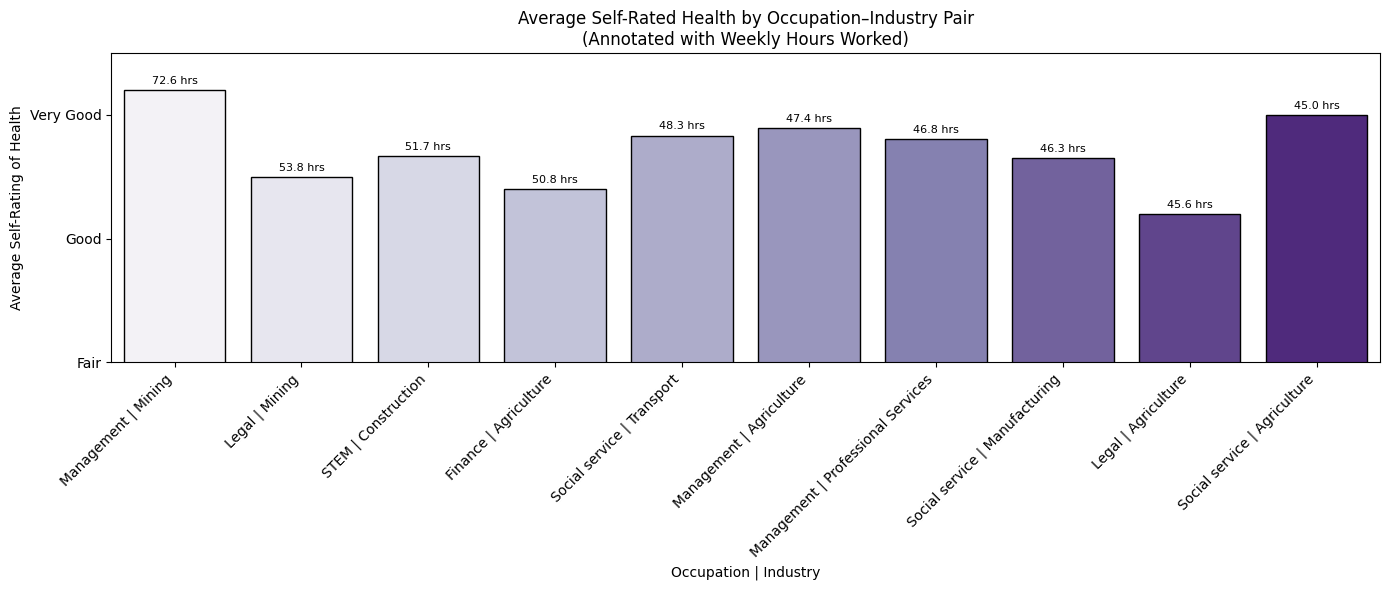

In [59]:
perception_map = {"Fair": 1, "Good": 2, "Very Good": 3, "Excellent": 4}
reverse_map = {v: k for k, v in perception_map.items()}
health_order = CategoricalDtype(categories=list(perception_map.keys()), ordered=True)
top_busiest_pairs['health_perception'] = top_busiest_pairs['health_perception'].astype(health_order)
top_busiest_pairs['health_score'] = top_busiest_pairs['health_perception'].map(perception_map).astype(float)

grouped_health = (
    top_busiest_pairs
    .groupby('occupation_industry')[['health_score', 'hours_worked']]
    .mean()
    .sort_values(by='hours_worked', ascending=False)
    .reset_index())

plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=grouped_health,
    x='occupation_industry',
    y='health_score',
    palette='Purples',
    edgecolor='black')
for i, row in grouped_health.iterrows():
    ax.text(i, row['health_score'] + 0.05, f"{row['hours_worked']:.1f} hrs", 
            ha='center', fontsize=8, color='black')
plt.yticks(
    ticks=[1, 2, 3, 4],
    labels=[reverse_map[i] for i in [1, 2, 3, 4]])
plt.ylim(1, 3.5)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Self-Rating of Health')
plt.xlabel('Occupation | Industry')
plt.title('Average Self-Rated Health by Occupation–Industry Pair\n(Annotated with Weekly Hours Worked)')
plt.tight_layout()
plt.savefig('results/meps_busiestcareers_healthrating.png')
plt.show()

/tmp/ipykernel_1256/1509863263.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['occupation_industry', 'health_perception'])


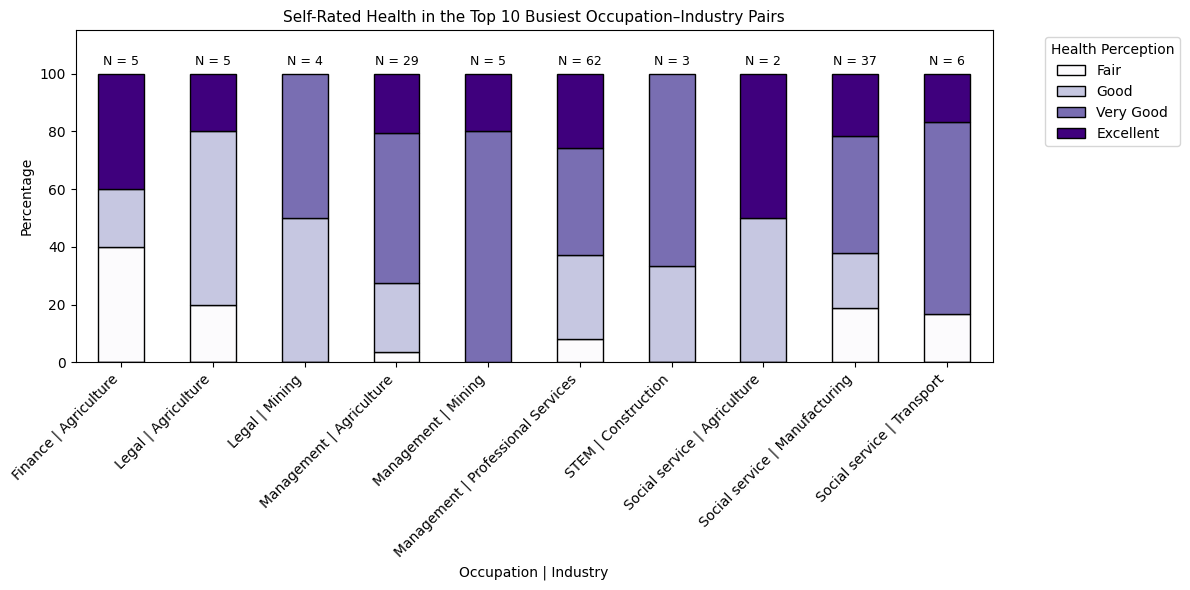

In [60]:
count_faps_cleaned = (
    top_busiest_pairs
    .groupby(['occupation_industry', 'health_perception'])
    .size()
    .reset_index(name='count'))
count_faps_cleaned['percentage'] = (
    count_faps_cleaned
    .groupby('occupation_industry')['count']
    .transform(lambda x: (x / x.sum()) * 100))
pivot_faps_cleaned = (
    count_faps_cleaned
    .pivot(index='occupation_industry', columns='health_perception', values='percentage')
    [["Fair", "Good", "Very Good", "Excellent"]])
n_per_group = (
    count_faps_cleaned
    .groupby('occupation_industry')['count']
    .sum())
ax = pivot_faps_cleaned.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='Purples',
    edgecolor='black')
for i, total in enumerate(n_per_group):
    ax.text(i, 102, f'N = {total}', ha='center', va='bottom', fontsize=9)
plt.ylabel('Percentage', fontsize=10)
plt.xlabel('Occupation | Industry', fontsize=10)
plt.title('Self-Rated Health in the Top 10 Busiest Occupation–Industry Pairs', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 115)
plt.legend(title='Health Perception', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'results/meps_healthperception_busiestcareers_stacked.png', dpi=300)
plt.show()

/tmp/ipykernel_1256/2720768622.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


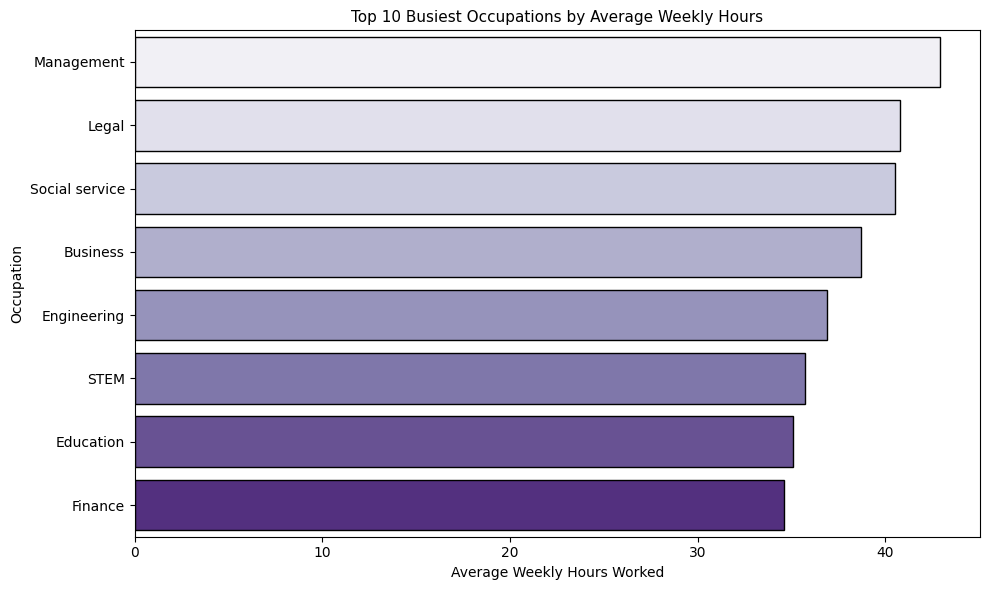

In [61]:
top_busiest_occupations = (
    meps_cleaned.groupby('occupation', as_index=False)['hours_worked']
    .mean()
    .sort_values(by='hours_worked', ascending=False)
    .round({'hours_worked': 1})
    .head(10))
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_busiest_occupations,
    x='hours_worked',
    y='occupation',
    palette='Purples',
    edgecolor='black')
plt.xlabel('Average Weekly Hours Worked', fontsize=10)
plt.ylabel('Occupation', fontsize=10)
plt.title('Top 10 Busiest Occupations by Average Weekly Hours', fontsize=11)
plt.tight_layout()
plt.savefig('results/meps_occupations_hours.png', dpi=300)
plt.show()

/tmp/ipykernel_1256/3714991901.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


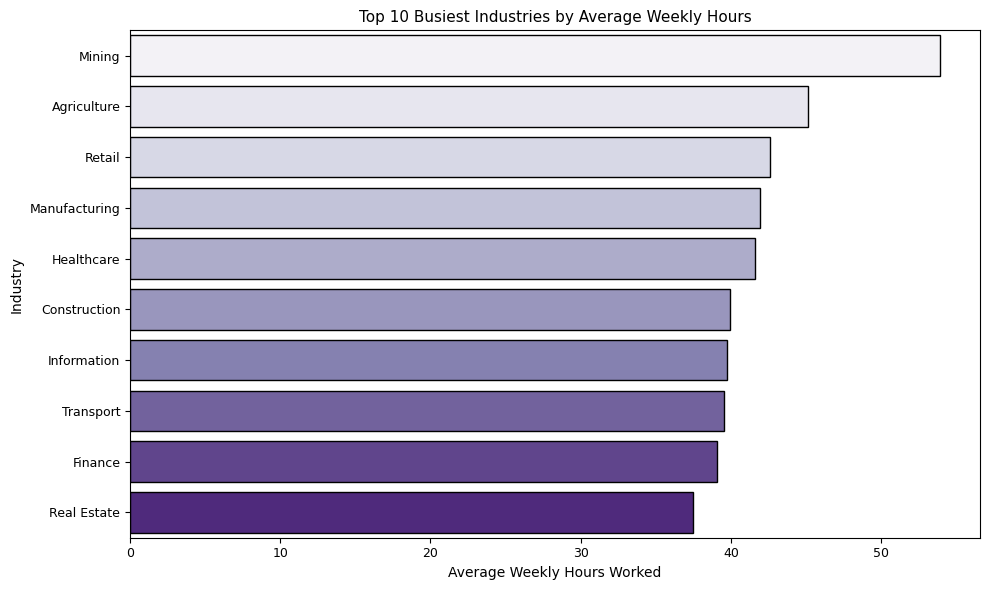

In [62]:
top_busiest_industries = (
    meps_cleaned.groupby('industry')['hours_worked']
    .mean()
    .reset_index()
    .sort_values(by='hours_worked', ascending=False)
    .head(10))
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_busiest_industries,
    x='hours_worked',
    y='industry',
    palette='Purples',
    edgecolor='black')
plt.title('Top 10 Busiest Industries by Average Weekly Hours', fontsize=11)
plt.xlabel('Average Weekly Hours Worked', fontsize=10)
plt.ylabel('Industry', fontsize=10)
plt.xlim(left=0)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig('results/meps_industries_hours.png', dpi=300)
plt.show()

In [63]:
top_occ = ['Management', 'Legal', 'Social service', 'Business', 'Engineering', 'STEM', 'Finance']
subset = meps_cleaned[meps_cleaned['occupation'].isin(top_occ)].copy()
subset['log_income'] = np.log1p(subset['total_income'].clip(lower=0))
subset['interaction_income_hours'] = subset['hours_worked'] * subset['log_income']

predictors = [
    'hours_worked', 'log_income', 'interaction_income_hours',
    'region', 'industry', 'occupation',
    'employer_insurance_offer', 'age_group']

subset = subset.dropna(subset=predictors + ['HEALTH_1'])
X = pd.get_dummies(subset[predictors], drop_first=True).astype(float)
y = subset['HEALTH_1'].astype(int)
X = X.dropna()
y = y.loc[X.index]

from statsmodels.miscmodels.ordinal_model import OrderedModel
model = OrderedModel(y, X, distr='logit')
results = model.fit(method='bfgs', disp=False)
print(results.summary())

with open('results/meps_model_summary.tex', 'w') as f:
    f.write(results.summary().as_latex())

                             OrderedModel Results                             
Dep. Variable:               HEALTH_1   Log-Likelihood:                -6888.2
Model:                   OrderedModel   AIC:                         1.385e+04
Method:            Maximum Likelihood   BIC:                         1.409e+04
Date:                Wed, 23 Apr 2025                                         
Time:                        03:09:51                                         
No. Observations:                5350                                         
Df Residuals:                    5314                                         
Df Model:                          32                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
hours_worked                       0.0258      0.022      1.177      0.239      -0.017     

# **FAPS vs. MEPS: comparison**

In [64]:
meps = pd.read_csv("data/derived/meps_cleaned.csv")
print("MEPS columns:\n", meps.columns.tolist())

MEPS columns:
 ['DUID', 'total_income', 'total_family_income', 'HEALTH_1', 'hours_worked', 'sex', 'relationship', 'health_perception', 'region', 'employment_status', 'industry', 'occupation', 'employer_insurance_offer', 'age_group']


In [65]:
faps = pd.read_csv(
    "data/derived/faps_individual_nutrients_household.csv",
    low_memory=False)
faps['age'] = pd.to_numeric(faps['age'], errors='coerce')
faps['education'] = faps['education'].astype(str)
faps['race'] = faps['race'].astype(str)
faps['sex'] = faps['sex'].astype(str)
faps['relationship'] = faps['relationship'].astype(str)
faps['region'] = faps['region'].astype(str)

In [66]:
print(faps.columns.tolist())

['bmi', 'self_rated_health', 'dinners_out_per_week', 'employment', 'education', 'race', 'hispanic', 'age', 'relationship', 'sex', 'hh_weight', 'person_id', 'hh_id', 'region', 'hh_size', 'hh_size_change', 'avg_hh_income', 'hh_self_employed', 'homeownership', 'liquid_assets', 'large_expenditure_shock', 'hh_food_secure', 'garden_ownership', 'garden_elsewhere', 'hunt_fish', 'hh_diet_quality', 'perceived_healthy_cost', 'perceived_healthy_time', 'financial_condition', 'hh_dinners_out', 'hh_meals_home', 'chol', 'protein', 'polyfat', 'monofat', 'satfat', 'totfat', 'totsug', 'dietfiber', 'carb', 'energy', 'food_group']


In [67]:
top_occ = top_busiest_occupations['occupation'].tolist()
subset = meps_cleaned[meps_cleaned['occupation'].isin(top_occ)].copy()

meps_region = subset.groupby('region').agg({
    'hours_worked': 'mean',
    'HEALTH_1': 'mean'}).rename(columns={
    'hours_worked': 'MEPS_avg_hours',
    'HEALTH_1': 'MEPS_avg_health'})

faps_region = hh_aggregated.groupby('region').agg({
    'processed_prop': 'mean',
    'stress_index_standardized': 'mean',
    'garden_ownership': 'mean',
    'perceived_healthy_cost': 'mean',
    'perceived_healthy_time': 'mean'}).rename(columns={
    'processed_prop': 'FAPS_avg_processed',
    'stress_index_standardized': 'FAPS_avg_stress',
    'garden_ownership': 'FAPS_pct_garden_ownership',
    'perceived_healthy_cost': 'FAPS_avg_perceived_healthy_cost',
    'perceived_healthy_time': 'FAPS_avg_perceived_healthy_time'})

comparison = meps_region.merge(faps_region, left_index=True, right_index=True)
print(comparison)


           MEPS_avg_hours  MEPS_avg_health  FAPS_avg_processed  \
region                                                           
Midwest         39.334234         2.316216            0.545571   
Northeast       37.199229         2.228792            0.501429   
South           38.450264         2.272465            0.574777   
West            38.461925         2.290230            0.498353   

           FAPS_avg_stress  FAPS_pct_garden_ownership  \
region                                                  
Midwest           0.031280                  25.067861   
Northeast        -0.066467                  23.959128   
South             0.105866                  17.844599   
West              0.103232                  23.100616   

           FAPS_avg_perceived_healthy_cost  FAPS_avg_perceived_healthy_time  
region                                                                       
Midwest                           0.356268                         0.193214  
Northeast                 

In [68]:
print(comparison.corr())

                                 MEPS_avg_hours  MEPS_avg_health  \
MEPS_avg_hours                         1.000000         0.981270   
MEPS_avg_health                        0.981270         1.000000   
FAPS_avg_processed                     0.506642         0.336404   
FAPS_avg_stress                        0.596851         0.596118   
FAPS_pct_garden_ownership              0.053214         0.168190   
FAPS_avg_perceived_healthy_cost       -0.124956        -0.129448   
FAPS_avg_perceived_healthy_time        0.738835         0.693923   

                                 FAPS_avg_processed  FAPS_avg_stress  \
MEPS_avg_hours                             0.506642         0.596851   
MEPS_avg_health                            0.336404         0.596118   
FAPS_avg_processed                         1.000000         0.430650   
FAPS_avg_stress                            0.430650         1.000000   
FAPS_pct_garden_ownership                 -0.648098        -0.573362   
FAPS_avg_perceived_heal

In [69]:
from scipy.stats import spearmanr

corr, pval = spearmanr(comparison['FAPS_avg_processed'], comparison['MEPS_avg_hours'])
print(f"Spearman rho = {corr:.3f}, p = {pval:.3f}")

Spearman rho = 0.000, p = 1.000


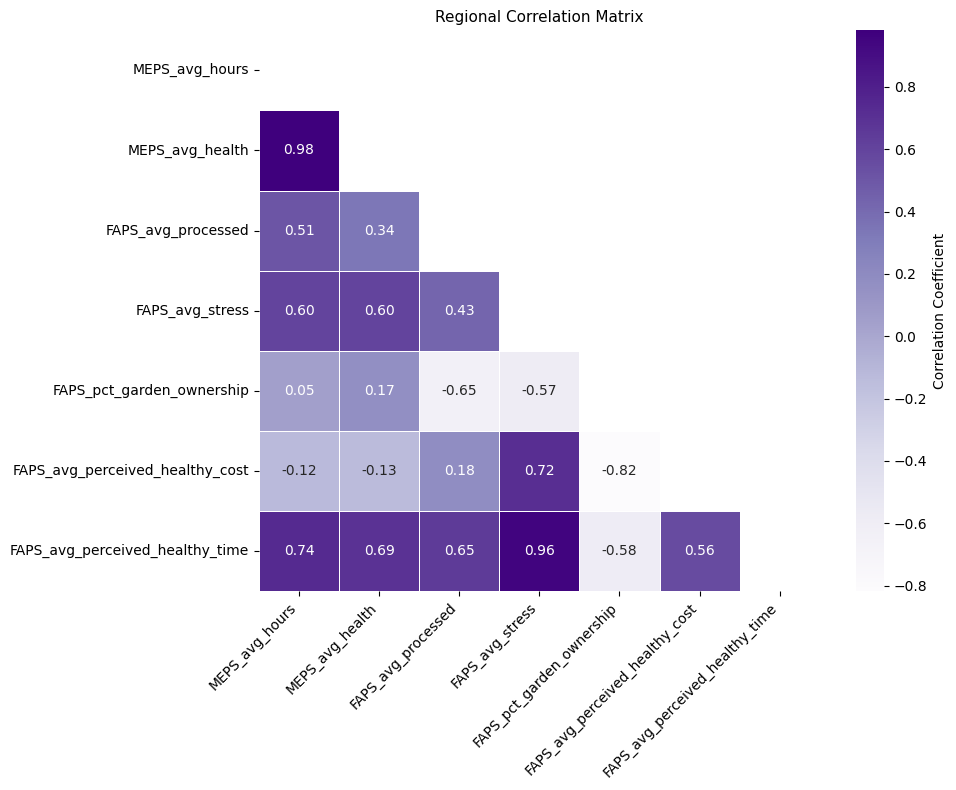

In [70]:
correlation_matrix = comparison.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="Purples",
    linewidths=0.5,
    square=True,
    cbar_kws={'label': 'Correlation Coefficient'},
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)))
plt.title("Regional Correlation Matrix", fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("results/final_correlation_heatmap.png", dpi=300)
plt.show()

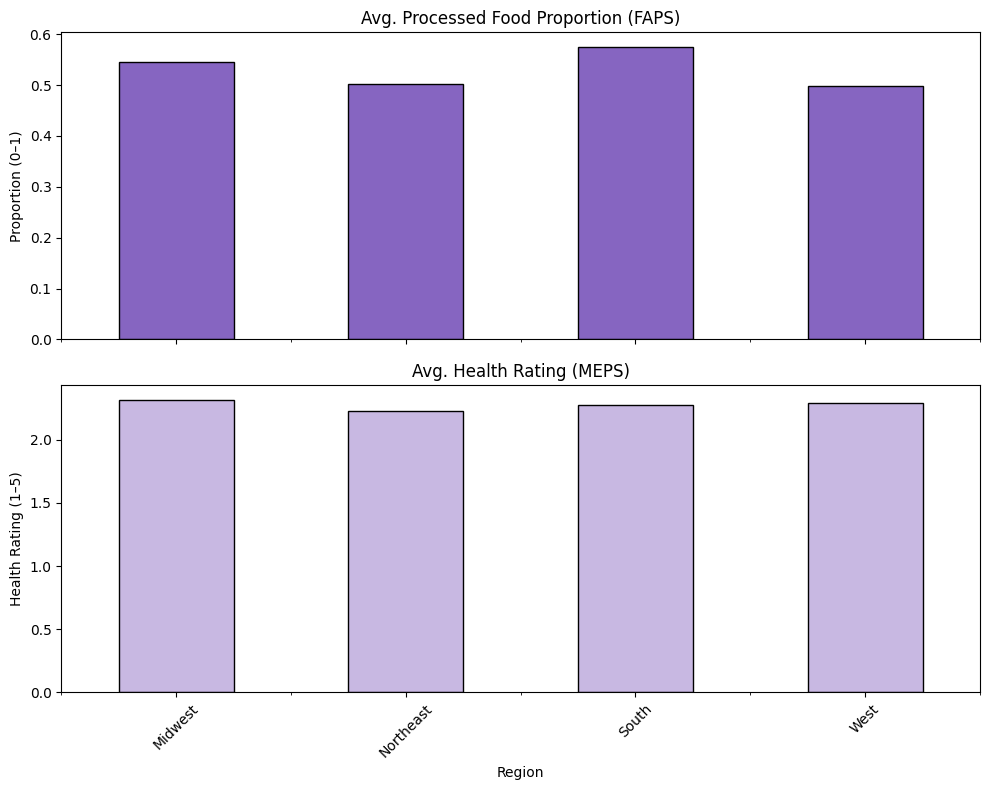

In [71]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

comparison['FAPS_avg_processed'].plot.bar(
    ax=axs[0], color='#8665c1', edgecolor='black')
axs[0].set_title("Avg. Processed Food Proportion (FAPS)")
axs[0].set_ylabel("Proportion (0–1)")

comparison['MEPS_avg_health'].plot.bar(
    ax=axs[1], color='#c8b8e2', edgecolor='black')
axs[1].set_title("Avg. Health Rating (MEPS)")
axs[1].set_ylabel("Health Rating (1–5)")

plt.xticks(rotation=45)
plt.xlabel("Region")
plt.tight_layout()
plt.savefig("results/final_healthrating_processed.png", dpi=300)
plt.show()

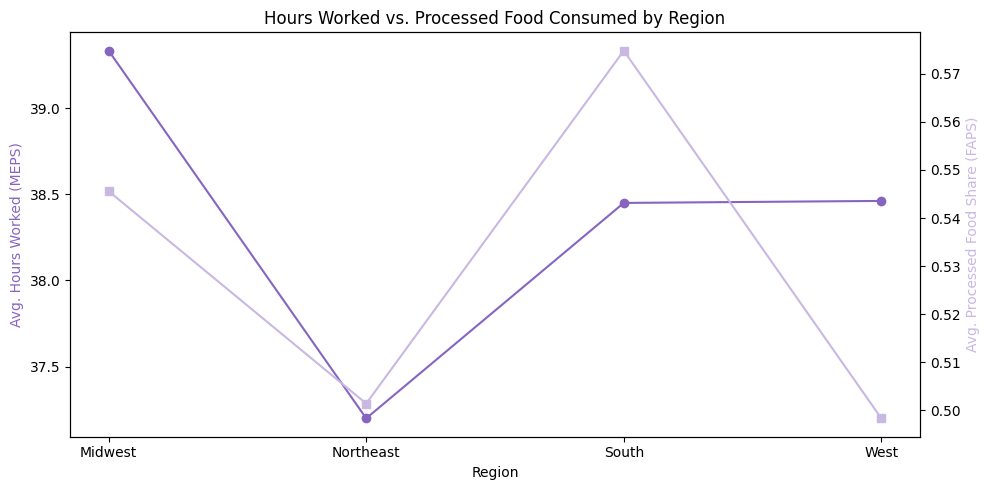

In [72]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

comparison['MEPS_avg_hours'].plot(kind='line', marker='o', ax=ax1, color='#8665c1', label='MEPS Av. Hours')
comparison['FAPS_avg_processed'].plot(kind='line', marker='s', ax=ax2, color='#c8b8e2', label='FAPS Avg. Processed Share')

ax1.set_ylabel('Avg. Hours Worked (MEPS)', color='#8665c1')
ax2.set_ylabel('Avg. Processed Food Share (FAPS)', color='#c8b8e2')
ax1.set_xlabel("Region")
ax1.set_xticks(range(len(comparison.index)))
ax1.set_xticklabels(comparison.index)
plt.title("Hours Worked vs. Processed Food Consumed by Region")
fig.tight_layout()
plt.savefig("results/final_hoursworked_processedfood_region.png", dpi=300)
plt.show()

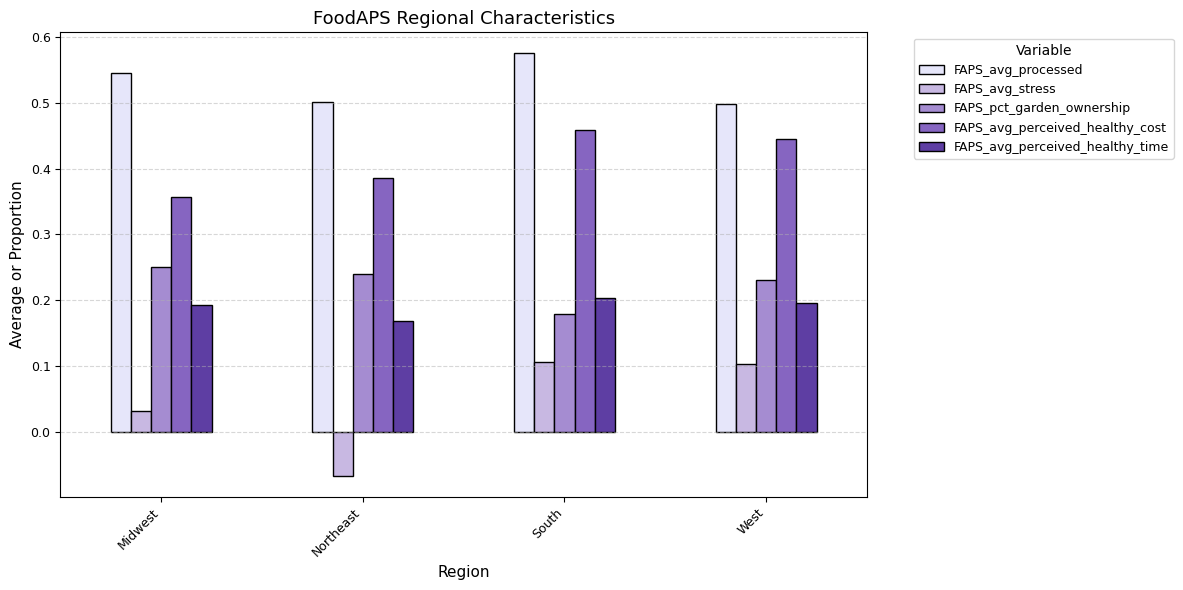

In [73]:
comparison = comparison[[
    'FAPS_avg_processed', 
    'FAPS_avg_stress', 
    'FAPS_pct_garden_ownership', 
    'FAPS_avg_perceived_healthy_cost', 
    'FAPS_avg_perceived_healthy_time']]
comparison['FAPS_pct_garden_ownership'] /= 100

comparison.plot(kind='bar', figsize=(12, 6), color=cool_purple_palette[:5], edgecolor='black')
plt.title("FoodAPS Regional Characteristics", fontsize=13)
plt.ylabel("Average or Proportion", fontsize=11)
plt.xlabel("Region", fontsize=11)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("results/final_region_bar.png", dpi=300)
plt.show()

In [74]:
import geopandas as gpd

In [75]:
regions = gpd.read_file("data/raw/cb_2018_us_region_500k.shp")
print(regions.columns)

Index(['REGIONCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER',
       'geometry'],
      dtype='object')


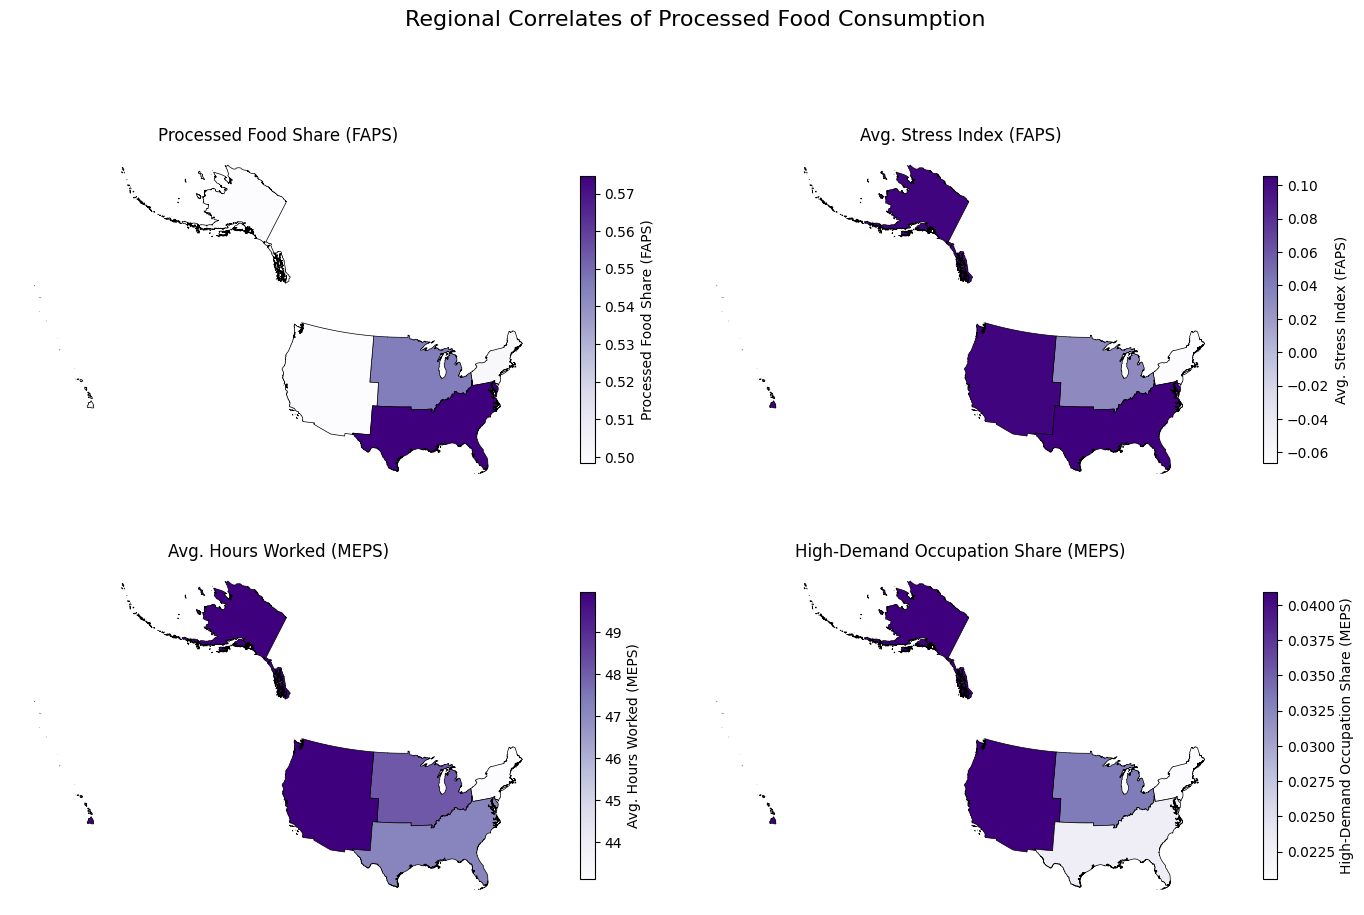

In [76]:
top_busiest_combos = (
    meps_cleaned
    .groupby(['occupation', 'industry'])['hours_worked']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)
meps_subset = meps_cleaned[
    meps_cleaned.apply(
        lambda row: (row['occupation'], row['industry']) in 
                    list(zip(top_busiest_combos['occupation'], top_busiest_combos['industry'])), 
        axis=1
    )
].copy()
meps_region = meps_subset.groupby('region').agg({
    'hours_worked': 'mean',
    'HEALTH_1': 'mean'
}).rename(columns={
    'hours_worked': 'MEPS_avg_hours',
    'HEALTH_1': 'MEPS_avg_health'
})
meps_cleaned['top_busiest'] = meps_cleaned.apply(
    lambda row: (row['occupation'], row['industry']) in 
                list(zip(top_busiest_combos['occupation'], top_busiest_combos['industry'])), 
    axis=1
).astype(int)
top_busiest_share = meps_cleaned.groupby('region')['top_busiest'].mean().rename('top_busiest_share')

comparison = faps_region.merge(meps_region, on='region')
comparison = comparison.merge(top_busiest_share, on='region')
comparison.index.name = 'region'
comparison_reset = comparison.copy()
comparison_reset['NAME'] = comparison_reset.index
regions_projected = regions.to_crs("EPSG:5070")
map_data = regions_projected.merge(comparison_reset, on='NAME', how='left')
map_data = map_data[~map_data['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

variables_to_plot = {
    "FAPS_avg_processed": "Processed Food Share (FAPS)",
    "FAPS_avg_stress": "Avg. Stress Index (FAPS)",
    "MEPS_avg_hours": "Avg. Hours Worked (MEPS)",
    "top_busiest_share": "High-Demand Occupation Share (MEPS)"
}
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, (col, title) in enumerate(variables_to_plot.items()):
    map_data.plot(
        column=col,
        cmap='Purples',
        edgecolor='black',
        linewidth=0.5,
        legend=True,
        ax=axes[i],
        legend_kwds={'label': title, 'shrink': 0.6}
    )
    axes[i].set_title(title, fontsize=12)
    axes[i].axis('off')
plt.suptitle("Regional Correlates of Processed Food Consumption", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("results/final_map_grid.png", dpi=400)
plt.show()